<a href="https://colab.research.google.com/github/venuannamdas/strokeXmeeti/blob/master/Stroke_Austria_Data_INSIGHTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem 2: Build a classification model to predict stroke
(= 1 if a person had a stroke else 0).

Data - https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


**Solution Steps**

Problem Statement: To Build a regression model for the goal of predicting strokes.

Problem Type: Classification and a "stroke" (constitutes a positive class) and "no stroke" (negative class).


Solution: Application of six Machine Learning Algorithms/strategies such as  (1) logistic regression 2) logistic regression-Regularization. (2) Support Vector Machine, (4) SVM-Hyper tuned (5)KNN (6) KNN-with cross-validation. Additionally, to handle unbalanced, employed class weights and Minority-Over Sampling was adopted. Finally, Target Variable i.e. stroke regression results are obtained


#1.Dataset Loading

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import KFold, GridSearchCV


from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler

from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shutil

In [2]:
# Loading dataset from a csv formatted file
stroke_file = 'https://raw.githubusercontent.com/venuannamdas/Data2023/master/healthcare-dataset-stroke-data.csv'
stroke=pd.read_csv(stroke_file)

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 2. Understanding the Data
Data Pre-processing
*   Data quality assessment
*   Data cleaning
*   Data transformation
*   Data reduction

In [4]:
#shape of dataset
print("shape of dataframe is : ", stroke.shape)
# summary of data
print(stroke.info())
#Get Statistical details of data
print(stroke.describe())
# Number of unique values in each column
unique_value_counts = stroke.nunique()
print("Number of Unique Values in Each Column:")
print(unique_value_counts)

shape of dataframe is :  (5110, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5

There are a total of 12 variables in this dataset, with a total of 5110 observations. “stroke” is our Target Variable, which has two categories encoded as 1 (stroke) and 0 (no stroke) rest all are input features. In addition, we can observe that our dataset contains both numerical and Categorical features.

**Data Cleaning**

In [5]:
stroke.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


We’ll now drop the id column because it’s merely a unique identifier, and
then verify each field in the dataset for null values.

In [6]:
#Drop id column as it is just a unique id
stroke.drop("id",inplace=True,axis=1)

<Axes: >

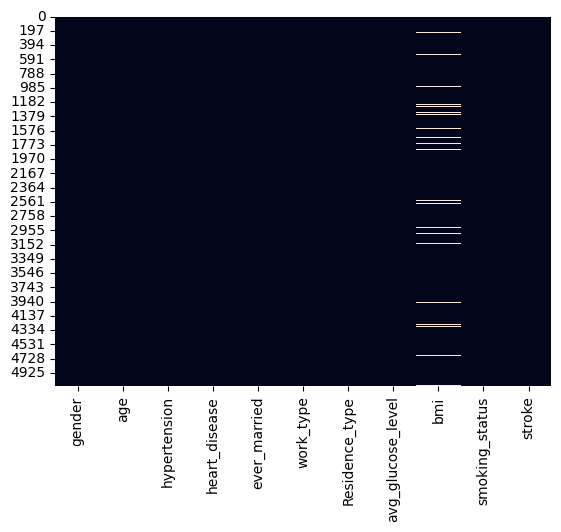

In [7]:
# Missing data Investigation (let us first start with numerical columns)
sns.heatmap(stroke.isnull(), cbar=False)

There is some missing data as indicated by while lines in column 'bmi (This is for numerical columns). let us verify and find null value %

In [8]:
stroke.isnull().mean()*100

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

Confirmed, only bmi has some null values

**Handling missing values :**
bmi is usually related to height, weight. it is depedent on age for children and teens but not for adults. Let us look at  age and bmi columns and apply logic to fill them. (source of observation: https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html )

In [9]:
stroke[['age', 'bmi']].head(5)

,age,bmi
0,67.0,36.6
1,61.0,NaN
2,80.0,32.5
3,49.0,34.4
4,79.0,24.0


let us use age as a criterion to fill missing values in bmi as follows

In [10]:
'''age >21 is adult, 13-21 represents teen and < 13 is considered children group.
 the average BMI is based on age group. the missing values are assigned based
 on age group '''

# Define age bins
age_bins = [0, 13, 21, float('inf')]
age_labels = ['<13', '13-21', '>21']

# Categorize age into bins
stroke['age_group'] = pd.cut(stroke['age'], bins=age_bins, labels=age_labels, right=False)

# Calculate mean BMI for each age group
bmi_mean_by_age_group = stroke.groupby('age_group')['bmi'].mean()

# Function to fill missing BMI values based on age group means
def fill_missing_bmi(row, age_group_means):
    if pd.isnull(row['bmi']):
        return age_group_means[row['age_group']]
    return row['bmi']

# Apply the function to fill missing BMI values
stroke['bmi'] = stroke.apply(lambda row: fill_missing_bmi(row, bmi_mean_by_age_group), axis=1)

print(stroke[['age', 'bmi']].head(5))

    age        bmi
0  67.0  36.600000
1  61.0  30.604579
2  80.0  32.500000
3  49.0  34.400000
4  79.0  24.000000


<Axes: >

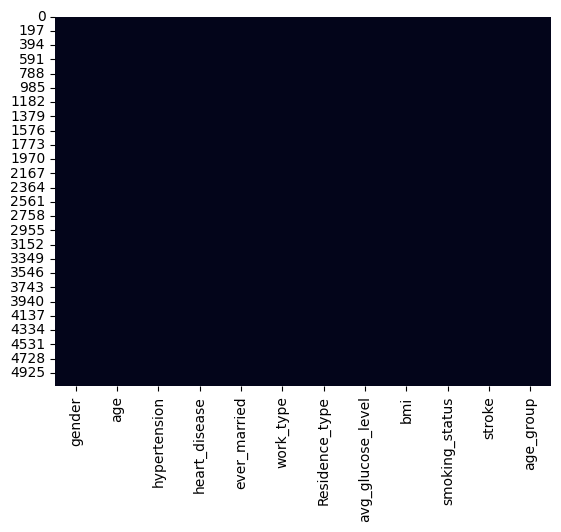

In [11]:
sns.heatmap(stroke.isnull(), cbar=False)

Now, we do not have any null or missing values in our data. So, let’s
proceed to our next step.

In [25]:
stroke.size

61320

In [20]:
pip install opencage


Creating vienna, austria co-ordinates

In [23]:
from opencage.geocoder import OpenCageGeocode
import pandas as pd

# Replace 'YOUR_API_KEY' with your actual OpenCage Geocoder API key
api_key = 'a0f8128716bf494a8897fe62c96701f7'

# Initialize the geocoder with your API key
geocoder = OpenCageGeocode(api_key)

# List of places in Vienna, Austria for which you want to fetch coordinates
places = [
    "St. Stephen's Cathedral, Vienna, Austria",
    "Schönbrunn Palace, Vienna, Austria",
    "Belvedere Palace, Vienna, Austria",
    "Hofburg Palace, Vienna, Austria",
    "Prater Park, Vienna, Austria",
    "Kunsthistorisches Museum, Vienna, Austria",
    "Naschmarkt, Vienna, Austria",
    "Vienna State Opera, Vienna, Austria",
    "Albertina Museum, Vienna, Austria",
    "Rathaus, Vienna, Austria",
    "Kärntnertor Theater, Vienna, Austria",
    "Votivkirche, Vienna, Austria",
    "Hundertwasserhaus, Vienna, Austria",
    "Graben, Vienna, Austria",
    "Sisi Museum, Vienna, Austria",
    "Heldenplatz, Vienna, Austria",
    "Wurstelprater, Vienna, Austria",
    "Leopold Museum, Vienna, Austria",
    "Schwarzenbergplatz, Vienna, Austria",
    "Haus des Meeres, Vienna, Austria"
]

# Initialize empty lists to store data
data = {
    'Place': [],
    'Latitude': [],
    'Longitude': []
}

# Fetch coordinates for each place and store in the data dictionary
for place in places:
    results = geocoder.geocode(place)
    if results and 'geometry' in results[0]:
        data['Place'].append(place)
        data['Latitude'].append(results[0]['geometry']['lat'])
        data['Longitude'].append(results[0]['geometry']['lng'])

# Create a DataFrame from the data dictionary
df_mitaly = pd.DataFrame(data)

# Print the DataFrame
print(df_mitaly)

# Save the DataFrame to a CSV file if needed
df_mitaly.to_csv('vienna_coordinates.csv', index=False)



                                        Place   Latitude  Longitude
0    St. Stephen's Cathedral, Vienna, Austria  48.208492  16.373127
1          Schönbrunn Palace, Vienna, Austria  48.184989  16.311568
2           Belvedere Palace, Vienna, Austria  48.191072  16.379761
3             Hofburg Palace, Vienna, Austria  48.206329  16.365626
4                Prater Park, Vienna, Austria  48.208490  16.372080
5   Kunsthistorisches Museum, Vienna, Austria  48.203739  16.361782
6                 Naschmarkt, Vienna, Austria  48.197728  16.361819
7         Vienna State Opera, Vienna, Austria  48.203286  16.369193
8           Albertina Museum, Vienna, Austria  48.208490  16.372080
9                    Rathaus, Vienna, Austria  48.210826  16.356573
10       Kärntnertor Theater, Vienna, Austria  48.208490  16.372080
11               Votivkirche, Vienna, Austria  48.215415  16.359140
12         Hundertwasserhaus, Vienna, Austria  48.207384  16.393941
13                    Graben, Vienna, Austria  4

#3.Exploratory Data Analysis

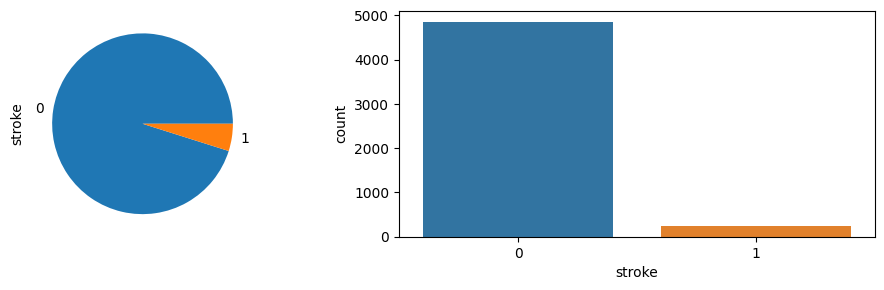

In [12]:
#Let’s look at the target variable’s distribution in the dataset.

# cchart for distribution of target variable
fig= plt.figure(figsize=(10,3) )
fig.add_subplot(1,2,1)
a= stroke["stroke"].value_counts(normalize=True).plot.pie()
fig.add_subplot(1,2,2)
churnchart=sns.countplot(x=stroke["stroke"])
plt.tight_layout()
plt.show()

# ADDING NEW DATA OF LATITUDE AND LONGITUDE RANDOMLY TO THE STROKE dataset

In [29]:
import numpy as np

# Assuming df_mitaly has 20 rows
# Create an array of randomly selected indices from df_mitaly with replacement
random_indices = np.random.choice(df_mitaly.index, size=len(stroke), replace=True)

# Create a new DataFrame by repeating rows of df_mitaly based on random_indices
random_df_mitaly = df_mitaly.loc[random_indices]

# Reset the index to avoid duplicate label issues
random_df_mitaly = random_df_mitaly.reset_index(drop=True)

# Assign the values to stroke
stroke[['Place', 'Latitude', 'Longitude']] = random_df_mitaly[['Place', 'Latitude', 'Longitude']]

In [13]:
# Save the trained model to a file
with open('1Model_Monday_Prob2_2BestResultOnly.pkl', 'wb') as model_file:
    pickle.dump(stroke, model_file)

We can observe from the above charts that, no stroke data is more than stroke data, indicating that there is a class imbalance because class 0 has more data points or observations than class 1

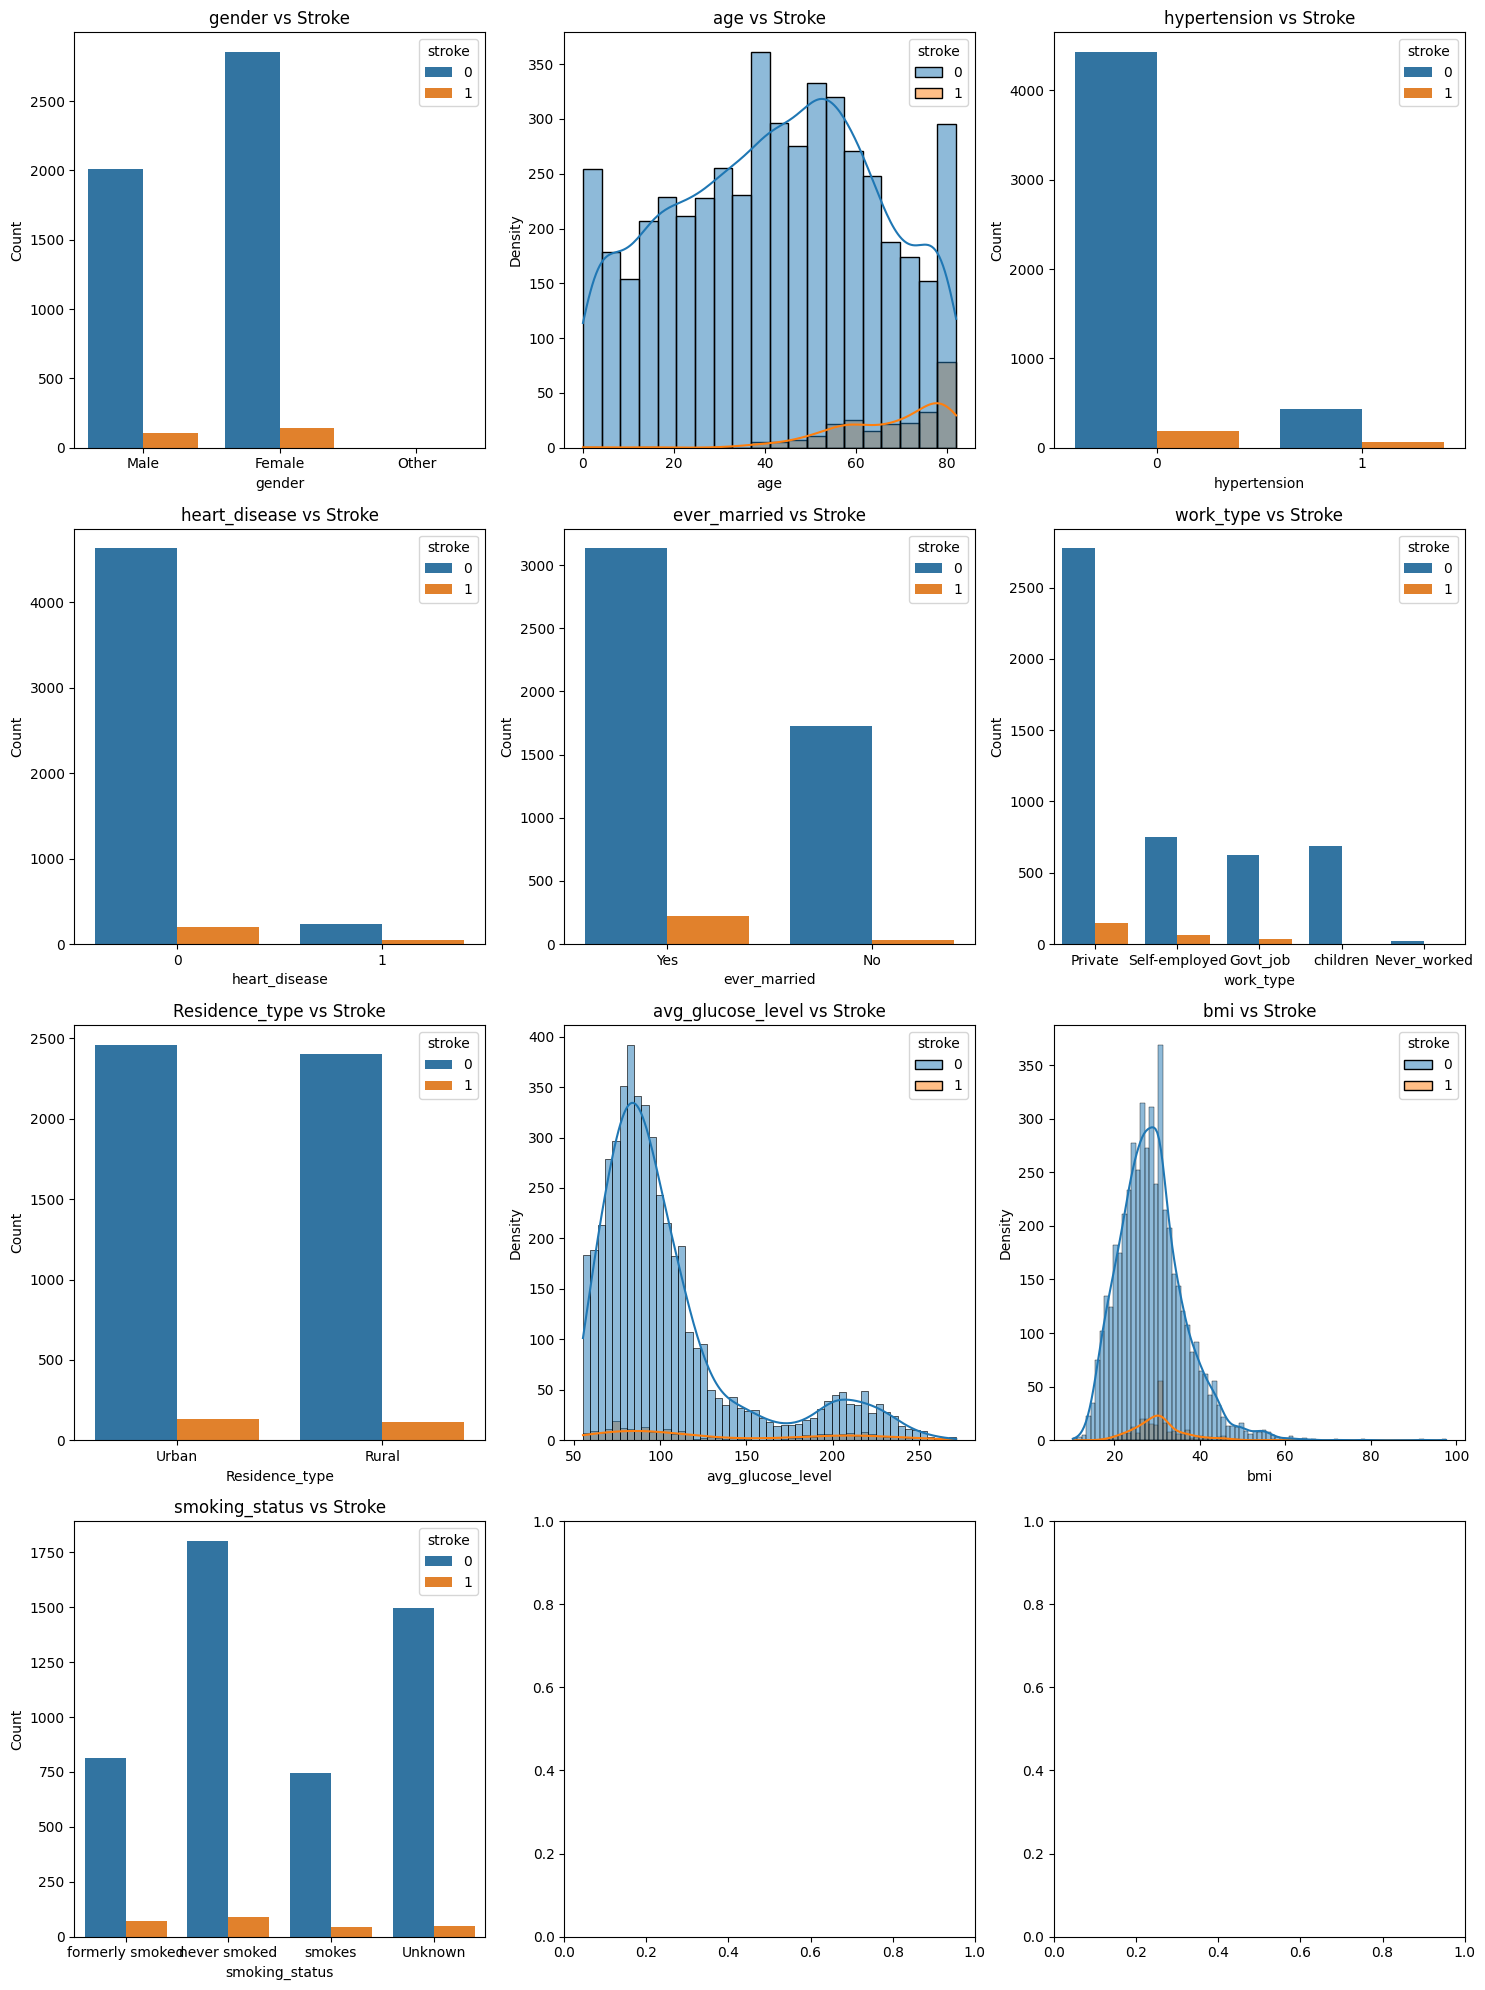

In [14]:
#Let’s visualize if there is any relationship between the target variable and other variables.

# Visualize relationship between stroke and other features
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 3, figsize=(15, 20))
predictor_variables = ["gender", "age", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "avg_glucose_level", "bmi", "smoking_status"]

for i, variable in enumerate(predictor_variables):
    row = i // 3
    col = i % 3

    # Histogram for categorical variables
    if variable in ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]:
        sns.countplot(x=stroke[variable], hue=stroke["stroke"], ax=axes[row, col])

    # Histogram for numerical variables
    elif variable in ["age", "avg_glucose_level", "bmi"]:
        sns.histplot(data=stroke, x=variable, hue="stroke", kde=True, ax=axes[row, col])

    # Box plot for numerical variables
    else:
        sns.boxplot(x=stroke["stroke"], y=stroke[variable], ax=axes[row, col])

    axes[row, col].set_title(f"{variable} vs Stroke")
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel("Count" if variable in ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"] else "Density")

plt.tight_layout()
plt.show()


we know that the classification is heavily bias towards no stroke. but let us also look at stroke==1 (stroke occurrence)

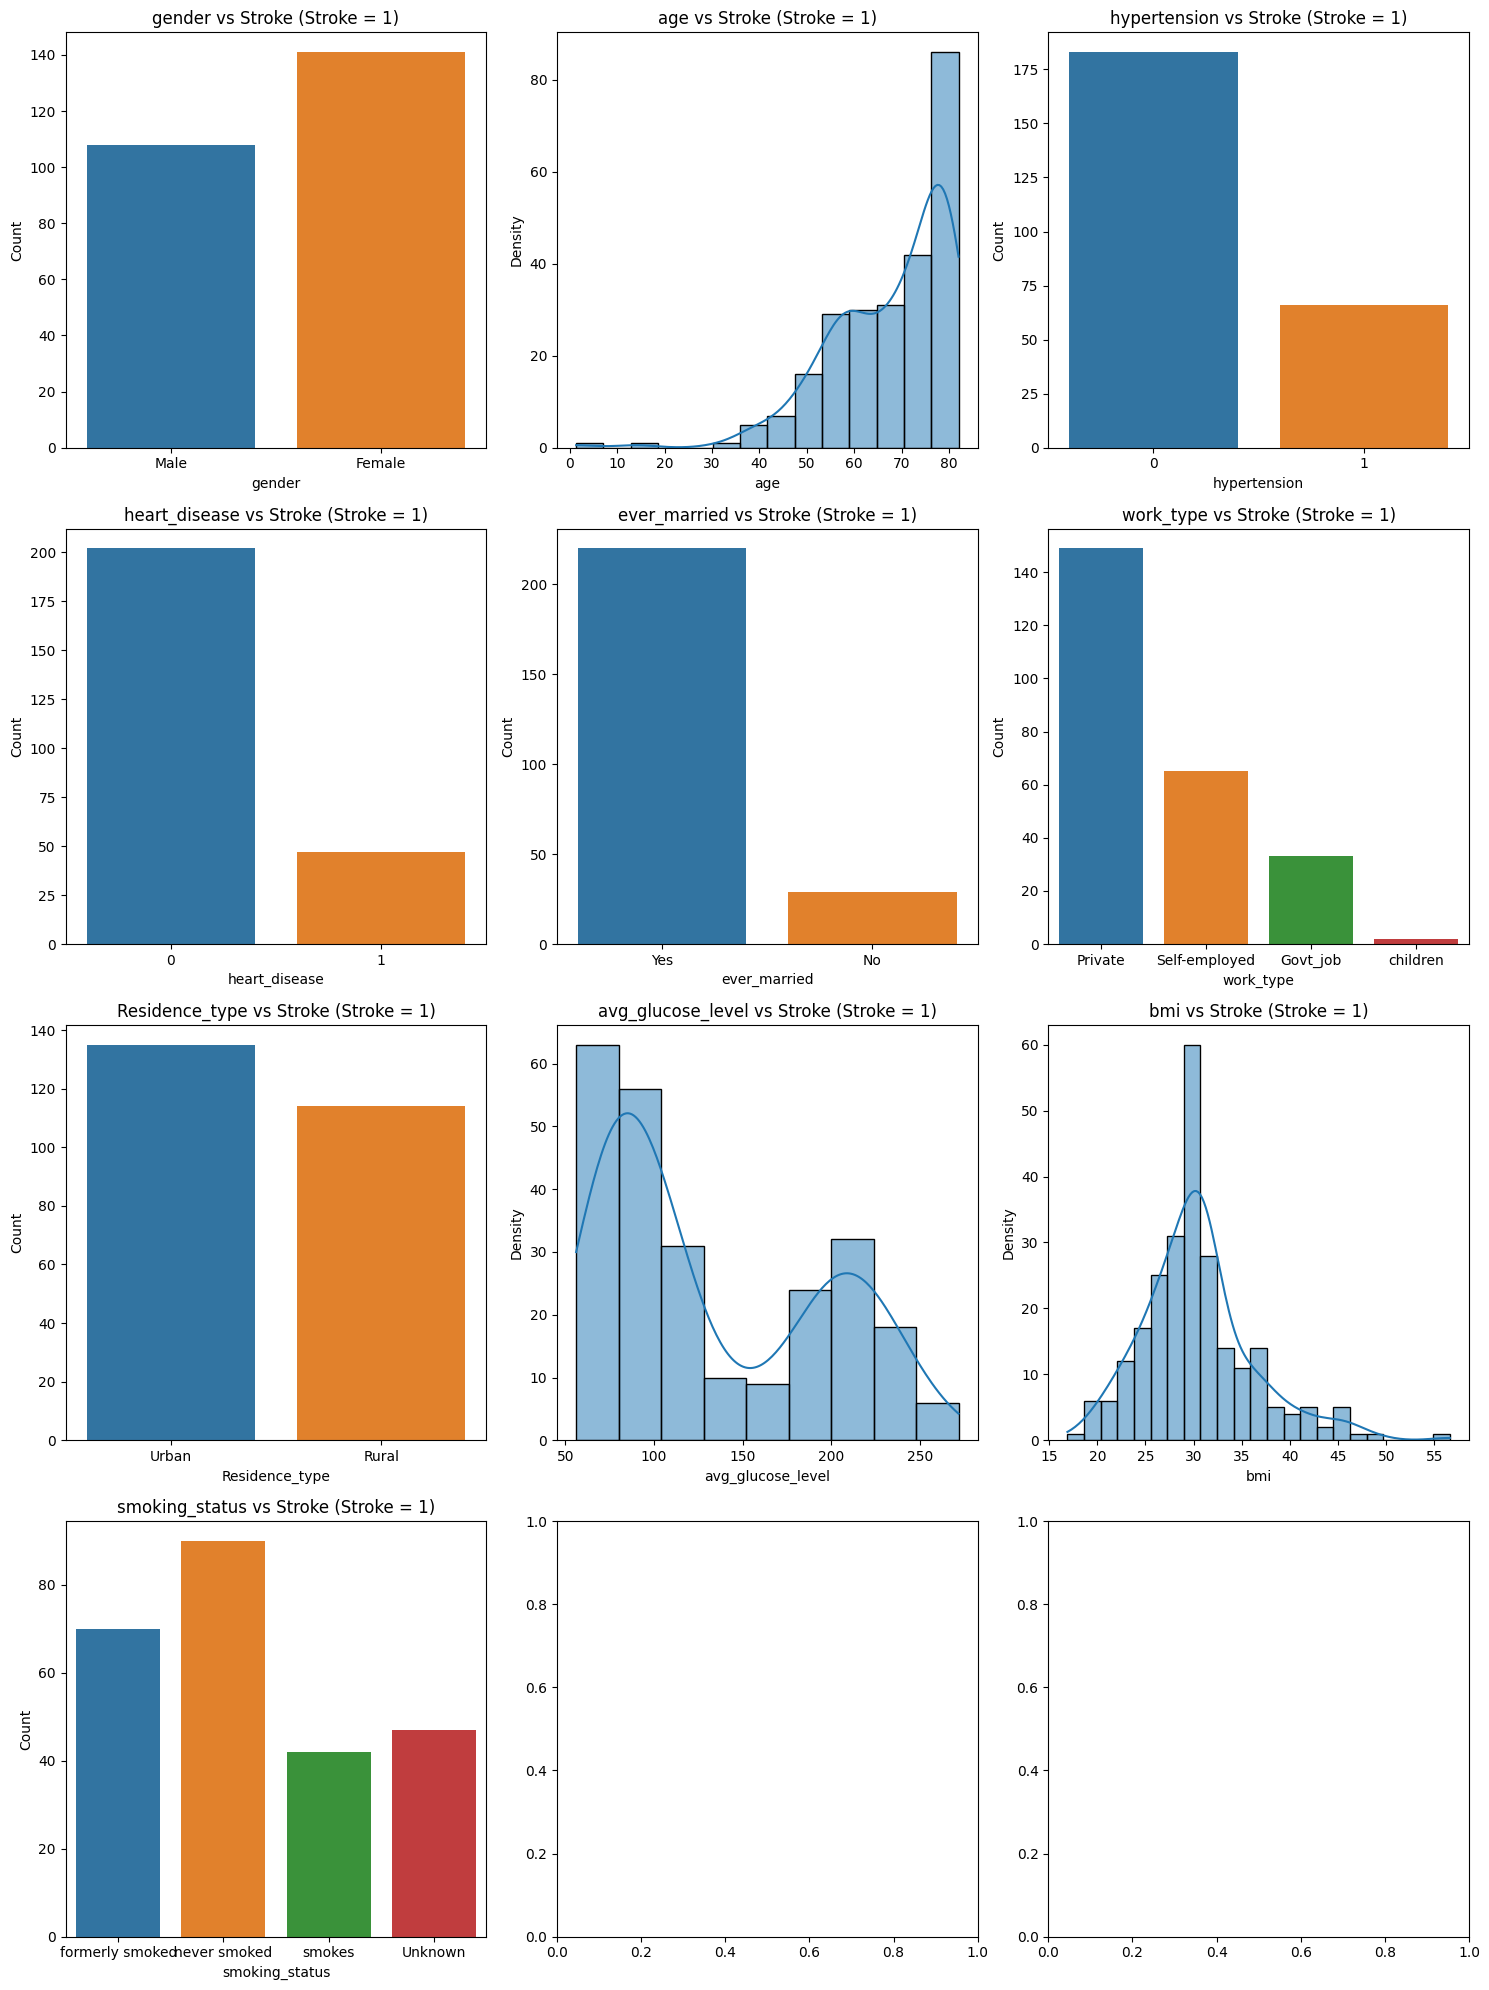

In [15]:
#let us look at the stroke data closely.

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 3, figsize=(15, 20))
predictor_variables = ["gender", "age", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "avg_glucose_level", "bmi", "smoking_status"]

for i, variable in enumerate(predictor_variables):
    row = i // 3
    col = i % 3

    # Filter data for stroke == 1
    stroke_subset = stroke[stroke["stroke"] == 1]

    # Histogram for categorical variables
    if variable in ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]:
        sns.countplot(x=variable, data=stroke_subset, ax=axes[row, col])

    # Histogram for numerical variables
    elif variable in ["age", "avg_glucose_level", "bmi"]:
        sns.histplot(data=stroke_subset, x=variable, kde=True, ax=axes[row, col])

    # Box plot for numerical variables
    else:
        sns.boxplot(x="stroke", y=variable, data=stroke_subset, ax=axes[row, col])

    axes[row, col].set_title(f"{variable} vs Stroke (Stroke = 1)")
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel("Count" if variable in ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"] else "Density")

plt.tight_layout()
plt.show()


stroke details -vienna, Austria on the world map

In [33]:
import pandas as pd

# Group the 'stroke' DataFrame by 'Place' and calculate category counts
grouped = stroke.groupby('Place')
summary_data = []
for place, group_data in grouped:
    category_counts = group_data[["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "avg_glucose_level", "smoking_status"]].apply(pd.value_counts).fillna(0)
    summary_data.append(category_counts)

# Create a summary DataFrame
summary_df = pd.concat(summary_data, keys=grouped.groups.keys())

# Rename the index level to 'Place'
summary_df.index = summary_df.index.set_names(['Place', 'Category'])

# Reset the index to make 'Place' and 'Category' columns
summary_df.reset_index(inplace=True)

# Save the summary DataFrame to a CSV file if needed
summary_df.to_csv('category_counts_summary.csv', index=False)

# Display the summary DataFrame
print(summary_df)


                                  Place         Category  gender  \
0     Albertina Museum, Vienna, Austria                0     0.0   
1     Albertina Museum, Vienna, Austria                1     0.0   
2     Albertina Museum, Vienna, Austria            55.28     0.0   
3     Albertina Museum, Vienna, Austria            55.72     0.0   
4     Albertina Museum, Vienna, Austria            55.96     0.0   
...                                 ...              ...     ...   
5378     Wurstelprater, Vienna, Austria              Yes     0.0   
5379     Wurstelprater, Vienna, Austria         children     0.0   
5380     Wurstelprater, Vienna, Austria  formerly smoked     0.0   
5381     Wurstelprater, Vienna, Austria     never smoked     0.0   
5382     Wurstelprater, Vienna, Austria           smokes     0.0   

      hypertension  heart_disease  ever_married  work_type  Residence_type  \
0            233.0          249.0           0.0        0.0             0.0   
1             33.0         

In [32]:
import geopandas as gpd
import folium
import pandas as pd

# Assuming you have a GeoDataFrame named 'gdf' with geographic data
# Limit the GeoDataFrame to the first 500 rows
gdf = gdf.head(500)  # Assuming 'gdf' contains the geographic data

# Create a map centered at a specific location (e.g., median latitude and longitude)
m = folium.Map(location=[gdf['Latitude'].median(), gdf['Longitude'].median()], zoom_start=6)

# Group the 'stroke' DataFrame by 'Place' and iterate over each group
grouped = stroke.groupby('Place')
for place, group_data in grouped:
    # Create a marker for each 'Place'
    popup_html = f"<b>{place}</b><br>"

    # Iterate over the rows in the group and add details to the popup
    for idx, row in group_data.iterrows():
        details = f"Gender: {row['gender']}<br>Age: {row['age']}<br>Hypertension: {row['hypertension']}<br>Heart Disease: {row['heart_disease']}<br>Married: {row['ever_married']}<br>Work Type: {row['work_type']}<br>Residence Type: {row['Residence_type']}<br>Avg Glucose Level: {row['avg_glucose_level']}<br>BMI: {row['bmi']}<br>Smoking Status: {row['smoking_status']}<br>Stroke: {row['stroke']}<br>"
        popup_html += details

    # Get the latitude and longitude from the 'gdf' GeoDataFrame for this 'Place'
    lat = gdf[gdf['Place'] == place]['Latitude'].values[0]
    lon = gdf[gdf['Place'] == place]['Longitude'].values[0]

    # Create a marker with the popup and add it to the map
    marker = folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_html, max_width=300),
    )
    marker.add_to(m)

# Add a title to the map
folium.TileLayer('cartodb positron').add_to(m)
folium.LayerControl().add_to(m)

# Save the map as an HTML file
m.save('stroke_details_by_place_map.html')



In [34]:
import geopandas as gpd
import folium
import pandas as pd

# Assuming you have a GeoDataFrame named 'gdf' with geographic data
# Limit the GeoDataFrame to the first 500 rows
gdf = gdf.head(500)  # Assuming 'gdf' contains the geographic data

# Create a map centered at a specific location (e.g., median latitude and longitude)
m = folium.Map(location=[gdf['Latitude'].median(), gdf['Longitude'].median()], zoom_start=6)

# Group the 'summary_df' DataFrame by 'Place' and iterate over each group
grouped = summary_df.groupby('Place')
for place, group_data in grouped:
    # Create a marker for each 'Place'
    popup_html = f"<b>{place}</b><br>"

    # Iterate over the rows in the group and add details to the popup
    for idx, row in group_data.iterrows():
        category_name = row['Category']
        count = row[0]  # Assuming the count column is at the second position (index 0)
        popup_html += f"{category_name}: {count}<br>"

    # Get the latitude and longitude from the 'gdf' GeoDataFrame for this 'Place'
    lat = gdf[gdf['Place'] == place]['Latitude'].values[0]
    lon = gdf[gdf['Place'] == place]['Longitude'].values[0]

    # Create a marker with the popup and add it to the map
    marker = folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_html, max_width=300),
    )
    marker.add_to(m)

# Add a title to the map
folium.TileLayer('cartodb positron').add_to(m)
folium.LayerControl().add_to(m)

# Save the map as an HTML file
m.save('category_counts_by_place_map.html')


In [36]:
import geopandas as gpd
import folium
import pandas as pd

# Assuming you have a GeoDataFrame named 'gdf' with geographic data
# Limit the GeoDataFrame to the first 500 rows
gdf = gdf.head(500)  # Assuming 'gdf' contains the geographic data

# Create a map centered at a specific location (e.g., median latitude and longitude)
m = folium.Map(location=[gdf['Latitude'].median(), gdf['Longitude'].median()], zoom_start=6)

# Group the 'stroke' DataFrame by 'Place' and iterate over each group
grouped = stroke.groupby('Place')

# Create a dictionary to store unique values summary for each attribute
unique_values_summary = {}

for place, group_data in grouped:
    # Create a marker for each 'Place'
    popup_html = f"<b>{place}</b><br>"

    # Specify the attributes to include in the summary
    attributes = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]

    # Iterate over the specified attributes
    for attribute in attributes:
        unique_values = group_data[attribute].unique()
        unique_count = len(unique_values)
        unique_values_summary[attribute] = {
            'values': unique_values,
            'count': unique_count
        }

        # Add the attribute summary to the popup
        popup_html += f"<b>{attribute}:</b> {', '.join(map(str, unique_values))} (Count: {unique_count})<br>"

    # Get the latitude and longitude from the 'gdf' GeoDataFrame for this 'Place'
    lat = gdf[gdf['Place'] == place]['Latitude'].values[0]
    lon = gdf[gdf['Place'] == place]['Longitude'].values[0]

    # Create a marker with the popup and add it to the map
    marker = folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_html, max_width=300),
    )
    marker.add_to(m)

# Add a title to the map
folium.TileLayer('cartodb positron').add_to(m)
folium.LayerControl().add_to(m)

# Save the map as an HTML file
m.save('unique_values_summary_by_place_map.html')

# Display the unique values summary
for attribute, summary in unique_values_summary.items():
    print(f"Attribute: {attribute}")
    print(f"Unique Values: {summary['values']}")
    print(f"Count: {summary['count']}")
    print()



Attribute: gender
Unique Values: ['Male' 'Female']
Count: 2

Attribute: hypertension
Unique Values: [1 0]
Count: 2

Attribute: heart_disease
Unique Values: [1 0]
Count: 2

Attribute: ever_married
Unique Values: ['Yes' 'No']
Count: 2

Attribute: work_type
Unique Values: ['Private' 'Self-employed' 'Govt_job' 'children']
Count: 4

Attribute: Residence_type
Unique Values: ['Rural' 'Urban']
Count: 2

Attribute: smoking_status
Unique Values: ['never smoked' 'Unknown' 'smokes' 'formerly smoked']
Count: 4



In [44]:
import geopandas as gpd
import folium
import pandas as pd

# Assuming you have a GeoDataFrame named 'gdf' with geographic data
# Limit the GeoDataFrame to the first 500 rows
gdf = gdf.head(5383)  # Assuming 'gdf' contains the geographic data

# Create a map centered at a specific location (e.g., median latitude and longitude)
m = folium.Map(location=[gdf['Latitude'].median(), gdf['Longitude'].median()], zoom_start=6)

# Group the 'stroke' DataFrame by 'Place' and iterate over each group
grouped = stroke.groupby('Place')

# Create a dictionary to store sub-category summary for each attribute
sub_category_summary = {}

for place, group_data in grouped:
    # Create a marker for each 'Place'
    popup_html = f"<b>{place}</b><br>"

    # Specify the attributes and their sub-categories to include in the summary
    attribute_sub_categories = {
        "gender": ["Male", "Female"],
        "hypertension": ["No", "Yes"],
        "heart_disease": ["No", "Yes"],
        "ever_married": ["No", "Yes"],
        "work_type": ["Govt_job", "Self-employed", "Private", "children", "Never_worked"],
        "Residence_type": ["Urban", "Rural"],
        "smoking_status": ["Unknown", "never smoked", "formerly smoked", "smokes"]
    }

    # Iterate over the specified attributes and their sub-categories
    for attribute, sub_categories in attribute_sub_categories.items():
        sub_category_counts = group_data[attribute].value_counts().reindex(sub_categories).fillna(0)
        sub_category_summary[attribute] = {
            'sub_categories': sub_categories,
            'counts': sub_category_counts
        }

        # Add the sub-category summary to the popup
        popup_html += f"<b>{attribute}:</b><br>"
        for sub_category in sub_categories:
            count = sub_category_counts[sub_category]
            popup_html += f"{sub_category}: {count}<br>"

    # Get the latitude and longitude from the 'gdf' GeoDataFrame for this 'Place'
    lat = gdf[gdf['Place'] == place]['Latitude'].values[0]
    lon = gdf[gdf['Place'] == place]['Longitude'].values[0]

    # Create a marker with the popup and add it to the map
    marker = folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_html, max_width=300),
    )
    marker.add_to(m)

# Add a title to the map
folium.TileLayer('cartodb positron').add_to(m)
folium.LayerControl().add_to(m)

# Save the map as an HTML file
m.save('sub_category_summary_by_place_map.html')

# Display the sub-category summary
for attribute, summary in sub_category_summary.items():
    print(f"Attribute: {attribute}")
    for sub_category, count in zip(summary['sub_categories'], summary['counts']):
        print(f"{sub_category}: {count}")
    print()


Attribute: gender
Male: 113
Female: 129

Attribute: hypertension
0: 218
1: 24

Attribute: heart_disease
0: 230
1: 12

Attribute: ever_married
No: 77
Yes: 165

Attribute: work_type
Govt_job: 26.0
Self-employed: 44.0
Private: 137.0
children: 35.0
Never_worked: 0.0

Attribute: Residence_type
Urban: 108
Rural: 134

Attribute: smoking_status
Unknown: 80
never smoked: 85
formerly smoked: 39
smokes: 38



Stroke on the map

In [119]:
import geopandas as gpd
import folium
import pandas as pd

# Assuming you have a GeoDataFrame named 'gdf' with geographic data
# Limit the GeoDataFrame to the first 5383 rows
gdf = gdf.head(5383)

# Create a map centered at a specific location (e.g., median latitude and longitude)
m = folium.Map(location=[gdf['Latitude'].median(), gdf['Longitude'].median()], zoom_start=6)

# Filter the 'stroke' DataFrame to select only rows where 'stroke' equals 1
stroke_with_stroke = stroke[stroke['stroke'] == 1]

# Group the filtered 'stroke' DataFrame by 'Place' and iterate over each group
grouped = stroke_with_stroke.groupby('Place')

# Create a dictionary to store sub-category summary for each attribute
sub_category_summary = {}

# Counter for adding numbers to markers
counter = 0

for place, group_data in grouped:
    # Calculate the total stroke cases at this place
    total_stroke_cases = len(group_data)

    # Create a popup HTML for each 'Place' including the total stroke cases and a table
    popup_html = f"<b>{place}</b><br>"
    popup_html += f"Total Stroke Cases at this Place: {total_stroke_cases}<br>"

    # Create a table for attribute sub-categories
    popup_html += "<table border='1' style='border-collapse: collapse; width: 100%;'>"
    popup_html += "<tr><th>Attribute</th><th>Sub-Category</th><th>Count</th></tr>"

    # Specify the attributes and their sub-categories to include in the summary
    attribute_sub_categories = {
        "gender": ["Male", "Female"],
        "hypertension": [0, 1],
        "heart_disease": [0, 1],
        "ever_married": ["No", "Yes"],
        "work_type": ["Govt_job", "Self-employed", "Private", "children", "Never_worked"],
        "Residence_type": ["Urban", "Rural"],
        "smoking_status": ["Unknown", "never smoked", "formerly smoked", "smokes"]
    }

    # Iterate over the specified attributes and their sub-categories
    for attribute, sub_categories in attribute_sub_categories.items():
        sub_category_counts = group_data[attribute].value_counts().reindex(sub_categories).fillna(0)

        # Add the attribute to the table only once for the first sub-category
        attribute_added = False

        for sub_category, count in zip(sub_categories, sub_category_counts):
            # Add the attribute and sub-category data to the table
            if not attribute_added:
                popup_html += f"<tr><td rowspan='{len(sub_categories)}'>{attribute}</td><td>{sub_category}</td><td>{count}</td></tr>"
                attribute_added = True
            else:
                popup_html += f"<tr><td>{sub_category}</td><td>{count}</td></tr>"

    # Close the table
    popup_html += "</table>"

    # Add the disclaimer and dedication
    popup_html += "<br>Preconditions such as hypertension and heart disease can also influence stroke. Where 0 indicates 'No' and 1 indicates 'Presence or Yes'. Both conditions can aggravate STROKE. "
    popup_html += "<br><br>This Project is dedicated to <b> Mrs. Mitaly Srivastava, </b> my former friend, who is currently a stroke patient in Vienna. May Lord help her in a speedy recovery. <br><br> <b> Disclaimer: </b> This study should be used only for educational purposes without any guarantee on the accuracy of information. This is designed by Dr. Venu Gopal Madhav Annamdas, PhD (NTU Singapore) based on data between 2004-2023 taken from the internet."

    # Get the latitude and longitude from the 'gdf' GeoDataFrame for this 'Place'
    lat = gdf[gdf['Place'] == place]['Latitude'].values[0]
    lon = gdf[gdf['Place'] == place]['Longitude'].values[0]

    # Increment the counter
    counter += 1

    # Create a marker with the popup and add it to the map
    marker = folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_html, max_width=500),  # Increase max_width for better display
        icon=folium.DivIcon(
            icon_size=(30, 30),
            icon_anchor=(15, 15),
            html=f'<div style="font-size: 12pt; text-align: center; background-color: #3186cc; color: white; border-radius: 50%; width: 30px; height: 30px; line-height: 30px;">{counter}</div>'
        )
    )
    marker.add_to(m)

# Add a title to the map
folium.TileLayer('cartodb positron').add_to(m)
folium.LayerControl().add_to(m)

# Add the footer note anywhere on the map with increased width
note_html = """
<div style="position: absolute; bottom: 10px; left: 10px; background-color: pink; padding: 10px; width: 2500%;">
    <p><b><h5>WELCOME: Its a awareness webpage on Stroke: </h5> a dangerous health condition:  LET US PLAY A SMALL GAME... </b> USE YOUR MOUSE ON SYSTEM OR FINGERS ON MOBILE,.. TRY TO ZOOM IN OR OUT AND FIND NUMBERS FROM 1 TO 20 ! .YOU CAN ALREADY SEE 15....  I HOPE YOU FOUND ALL THE NUMBERS. WOW WONDERFUL ! This page provides data insights of stroke patients in Vienna, Austria - Click on blue Markers (1-20) to know details of Stroke Patient at each famous place in Vienna.  It is important to have awareness of Stroke, which can occur due to multiple reasons including late pregnancies, with pre-existing conditions such as hypertension, heart disease. Occurs when the supply of blood to the brain is reduced or blocked completely, which prevents brain tissue from getting oxygen and nutrients. Urgent medical attention is usually recommended by healthcare providers. It is dangerous and life-threatening. This condition is treatable by a medical professional. However, it can last several years or be lifelong.</p>
    <p>This Project is dedicated to Mrs. Mitaly Srivastava, my former friend, who is a stroke patient in Vienna</h5></p>
</div>
"""

# Create a marker for the footer note
note_marker = folium.Marker(
    location=[48.1965716, 16.3215684],
    icon=folium.DivIcon(html=note_html),
)
note_marker.add_to(m)


# Save the map as an HTML file
m.save('STROKE_VIENNA_MITALY_SINGAPORE_VENU.html')


In [108]:
import geopandas as gpd
import folium
import pandas as pd

# Assuming you have a GeoDataFrame named 'gdf' with geographic data
# Limit the GeoDataFrame to the first 5383 rows
gdf = gdf.head(5383)

# Create a map centered at a specific location (e.g., median latitude and longitude)
m = folium.Map(location=[gdf['Latitude'].median(), gdf['Longitude'].median()], zoom_start=6)

# Filter the 'stroke' DataFrame to select only rows where 'stroke' equals 1
stroke_with_stroke = stroke[stroke['stroke'] == 1]

# Group the filtered 'stroke' DataFrame by 'Place' and iterate over each group
grouped = stroke_with_stroke.groupby('Place')

# Create a dictionary to store sub-category summary for each attribute
sub_category_summary = {}

# Counter for adding numbers to markers
counter = 0

for place, group_data in grouped:
    # Calculate the total stroke cases at this place
    total_stroke_cases = len(group_data)

    # Create a popup HTML for each 'Place' including the total stroke cases and a table
    popup_html = f"<b>{place}</b><br>"
    popup_html += f"Total Stroke Cases at this Place: {total_stroke_cases}<br>"

    # Create a table for attribute sub-categories
    popup_html += "<table border='1' style='border-collapse: collapse; width: 100%;'>"
    popup_html += "<tr><th>Attribute</th><th>Sub-Category</th><th>Count</th></tr>"

    # Specify the attributes and their sub-categories to include in the summary
    attribute_sub_categories = {
        "gender": ["Male", "Female"],
        "hypertension": [0, 1],
        "heart_disease": [0, 1],
        "ever_married": ["No", "Yes"],
        "work_type": ["Govt_job", "Self-employed", "Private", "children", "Never_worked"],
        "Residence_type": ["Urban", "Rural"],
        "smoking_status": ["Unknown", "never smoked", "formerly smoked", "smokes"]
    }

    # Iterate over the specified attributes and their sub-categories
    for attribute, sub_categories in attribute_sub_categories.items():
        sub_category_counts = group_data[attribute].value_counts().reindex(sub_categories).fillna(0)

        # Add the attribute to the table only once for the first sub-category
        attribute_added = False

        for sub_category, count in zip(sub_categories, sub_category_counts):
            # Add the attribute and sub-category data to the table
            if not attribute_added:
                popup_html += f"<tr><td rowspan='{len(sub_categories)}'>{attribute}</td><td>{sub_category}</td><td>{count}</td></tr>"
                attribute_added = True
            else:
                popup_html += f"<tr><td>{sub_category}</td><td>{count}</td></tr>"

    # Close the table
    popup_html += "</table>"

    # Add the disclaimer and dedication
    popup_html += "<br>Preconditions such as hypertension and heart disease can also influence stroke. Where 0 indicates 'No' and 1 indicates 'Presence or Yes'. Both conditions can aggravate STROKE. "
    popup_html += "<br><br>This Project is dedicated to <b> Mrs. Mitaly Srivastava, </b> my former friend, who is currently a stroke patient in Vienna. May Lord help her in a speedy recovery. <br><br> <b> Disclaimer: </b> This study should be used only for educational purposes without any guarantee on the accuracy of information. This is designed by Dr. Venu Gopal Madhav Annamdas, PhD (NTU Singapore) based on data between 2004-2023 taken from the internet."

    # Get the latitude and longitude from the 'gdf' GeoDataFrame for this 'Place'
    lat = gdf[gdf['Place'] == place]['Latitude'].values[0]
    lon = gdf[gdf['Place'] == place]['Longitude'].values[0]

    # Increment the counter
    counter += 1

    # Create a marker with the popup and add it to the map
    marker = folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_html, max_width=500),  # Increase max_width for better display
        icon=folium.DivIcon(
            icon_size=(30, 30),
            icon_anchor=(15, 15),
            html=f'<div style="font-size: 12pt; text-align: center; background-color: #3186cc; color: white; border-radius: 50%; width: 30px; height: 30px; line-height: 30px;">{counter}</div>'
        )
    )
    marker.add_to(m)

# Add a title to the map
folium.TileLayer('cartodb positron').add_to(m)
folium.LayerControl().add_to(m)

# Calculate the bounding box (bbox) to include all markers
bbox = gdf[['Latitude', 'Longitude']].values.tolist()
m.fit_bounds(bbox)

# Add the footer note anywhere on the map with increased width
note_html = """
<div style="position: absolute; bottom: 10px; left: 10px; background-color: white; padding: 10px; width: 2500%;">
    <p><b><h5>WELCOME: Its a awareness webpage on Stroke: </h5> a dangerous health condition:  </b> This page provides data insights of stroke patients in Vienna, Austria - Click on blue Markers (1-20) to know details of Stroke Patient at each famous place in Vienna.  It is important to have awareness of Stroke, which can occur due to multiple reasons including late pregnancies, with pre-existing conditions such as hypertension, heart disease. Occurs when the supply of blood to the brain is reduced or blocked completely, which prevents brain tissue from getting oxygen and nutrients. Urgent medical attention is usually recommended by healthcare providers. It is dangerous and life-threatening. This condition is treatable by a medical professional. However, it can last several years or be lifelong.</p>
    <p>This Project is dedicated to Mrs. Mitaly Srivastava, my former friend, who is a stroke patient in Vienna</h5></p>
</div>
"""

# Create a marker for the footer note
note_marker = folium.Marker(
    location=[48.1665716, 16.3215684],
    icon=folium.DivIcon(html=note_html),
)
note_marker.add_to(m)

# Save the map as an HTML file
m.save('stroke_VIENNA.html')



# The data is interesting and we can observed that
(a) Female has more chances of stroke
(b) Urban population has more chances of stroke.
(c) Private type of employment -has higher stroke cases
(d) bmi in the range of 27 -33 has high changes of stroke cases.
(e) people who never smoked can also get stroke
(f) lower glucose levels can have higher stroke cases.

The data shows that the stroke can occur to allmost all types of people, such as married, unmarried, children etc. One-Hot Encoding/ or any code can help us include all the options: note, there can be other option but i felt i should be all categories (married or not, children or sdults ...etc). We will do this for Gender, Residence_type, work_type, ever_married, smoking_status.

let us see outliers and try to trim the data as follows

Checking for outliers in numeric columns OF PREDICTOR VARIABLES using Z-score

In [16]:
import pandas as pd

# Assuming you have a DataFrame named 'stroke_encodedGRwEs'
# Replace this with your actual DataFrame

# Select numeric columns
numeric_columns = stroke.select_dtypes(include=['int64', 'float64'])

# Drop a single column by name
column_to_drop = 'stroke'  # Replace with the actual column name
numeric_columns = numeric_columns.drop(columns=[column_to_drop])

print("Numeric Columns:")
print(numeric_columns.head(5))

Numeric Columns:
    age  hypertension  heart_disease  avg_glucose_level        bmi
0  67.0             0              1             228.69  36.600000
1  61.0             0              0             202.21  30.604579
2  80.0             0              1             105.92  32.500000
3  49.0             0              0             171.23  34.400000
4  79.0             1              0             174.12  24.000000


In [17]:
# Set the threshold for Z-score based outlier detection
threshold = 3

# Create a DataFrame to store outliers
outliers = pd.DataFrame()

# Iterate through each numeric column
for col in numeric_columns.columns:
    col_mean = numeric_columns[col].mean()
    col_std = numeric_columns[col].std()

    # Calculate Z-scores for the column
    z_scores = (numeric_columns[col] - col_mean) / col_std

    # Identify and store the rows with Z-scores exceeding the threshold
    col_outliers = numeric_columns[abs(z_scores) > threshold]
    outliers = pd.concat([outliers, col_outliers])

# Print the DataFrame containing outliers
print(outliers.head(5))

     age  hypertension  heart_disease  avg_glucose_level   bmi
4   79.0             1              0             174.12  24.0
6   74.0             1              1              70.09  27.4
10  81.0             1              0              80.43  29.7
15  50.0             1              0             167.41  30.9
17  75.0             1              0             221.29  25.8


In [18]:
rows_ratio = outliers.shape[0] / stroke.shape[0]
(rows_ratio)*100

17.26027397260274

The outliers ratio is significant. Let us not remove these outliers here but need to discuss with stakeholders to arrive at some mutual understanding

In [19]:
stroke['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Data is heavily biased towards class 0, i.e no stroke as shown above.

#4. Feature Engineering
In feature engineering, we apply domain expertise to produce new features from raw data, or we convert or encode features. We’ll encode categorical features or make dummy features out of them in this section. Our predector variables are ["gender", "age", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "avg_glucose_level", "bmi", "smoking_status"]. LET US EXAMINE THEM


**1. Gender**

In [ ]:
gender_counts = stroke['gender'].value_counts()
print(gender_counts)


Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


we have one 'other', let us investigate this OBSERVATION.

In [ ]:
filtered_data = stroke[stroke['gender'] == 'Other']
filtered_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0,>21


In [ ]:
# This person donot have stroke. fOR SIMPLICITY, we can drop this OBSERVATION or merge with 'male'. let us merge it with male.
# Merge 'Other' gender rows with 'Male'
stroke.loc[stroke['gender'] == 'Other', 'gender'] = 'Male'

In [ ]:
stroke['gender'].value_counts()

Female    2994
Male      2116
Name: gender, dtype: int64

 Hot-encoding of gender

In [ ]:
stroke_encodedG = pd.get_dummies(stroke, columns=['gender'], prefix=['gender'])


In [ ]:
stroke_encodedG.sample(5)

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group,gender_Female,gender_Male
3093,32.0,0,0,Yes,Private,Rural,83.13,32.0,smokes,0,>21,0,1
1435,54.0,0,1,Yes,Private,Urban,140.28,37.1,formerly smoked,0,>21,1,0
2210,37.0,0,0,Yes,Private,Urban,60.61,35.7,formerly smoked,0,>21,1,0
2694,46.0,0,0,No,Govt_job,Rural,112.29,23.5,Unknown,0,>21,1,0
294,22.0,0,0,No,Private,Rural,79.81,27.7,Unknown,0,>21,1,0


**2. Others (Residence_type, work_type, ever_married, smoking_status)**

In [ ]:
stroke_encodedGR=pd.get_dummies(stroke_encodedG, columns=['Residence_type'], prefix=['Residence_type'])
stroke_encodedGRw=pd.get_dummies(stroke_encodedGR, columns=['work_type'], prefix=['work_type'])
stroke_encodedGRwE=pd.get_dummies(stroke_encodedGRw, columns=['ever_married'], prefix=['ever_married'])
stroke_encodedGRwEs=pd.get_dummies(stroke_encodedGRwE, columns=['smoking_status'], prefix=['smoking_status'])

In [ ]:
stroke_encodedGRwEs.sample(5)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age_group,gender_Female,gender_Male,Residence_type_Rural,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,ever_married_No,ever_married_Yes,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
420,75.0,0,0,94.29,35.2,0,>21,0,1,0,...,0,0,0,0,0,1,1,0,0,0
1253,11.0,0,0,92.17,19.5,0,<13,0,1,0,...,0,0,0,1,1,0,1,0,0,0
2159,42.0,0,0,65.66,33.7,0,>21,1,0,0,...,0,0,0,0,0,1,0,0,1,0
655,28.0,0,0,64.64,22.1,0,>21,1,0,1,...,0,1,0,0,0,1,0,0,1,0
1004,39.0,0,0,72.49,44.9,0,>21,0,1,1,...,0,0,0,0,0,1,0,1,0,0


We will plot correlations between different variables using a pair plot and heatmap

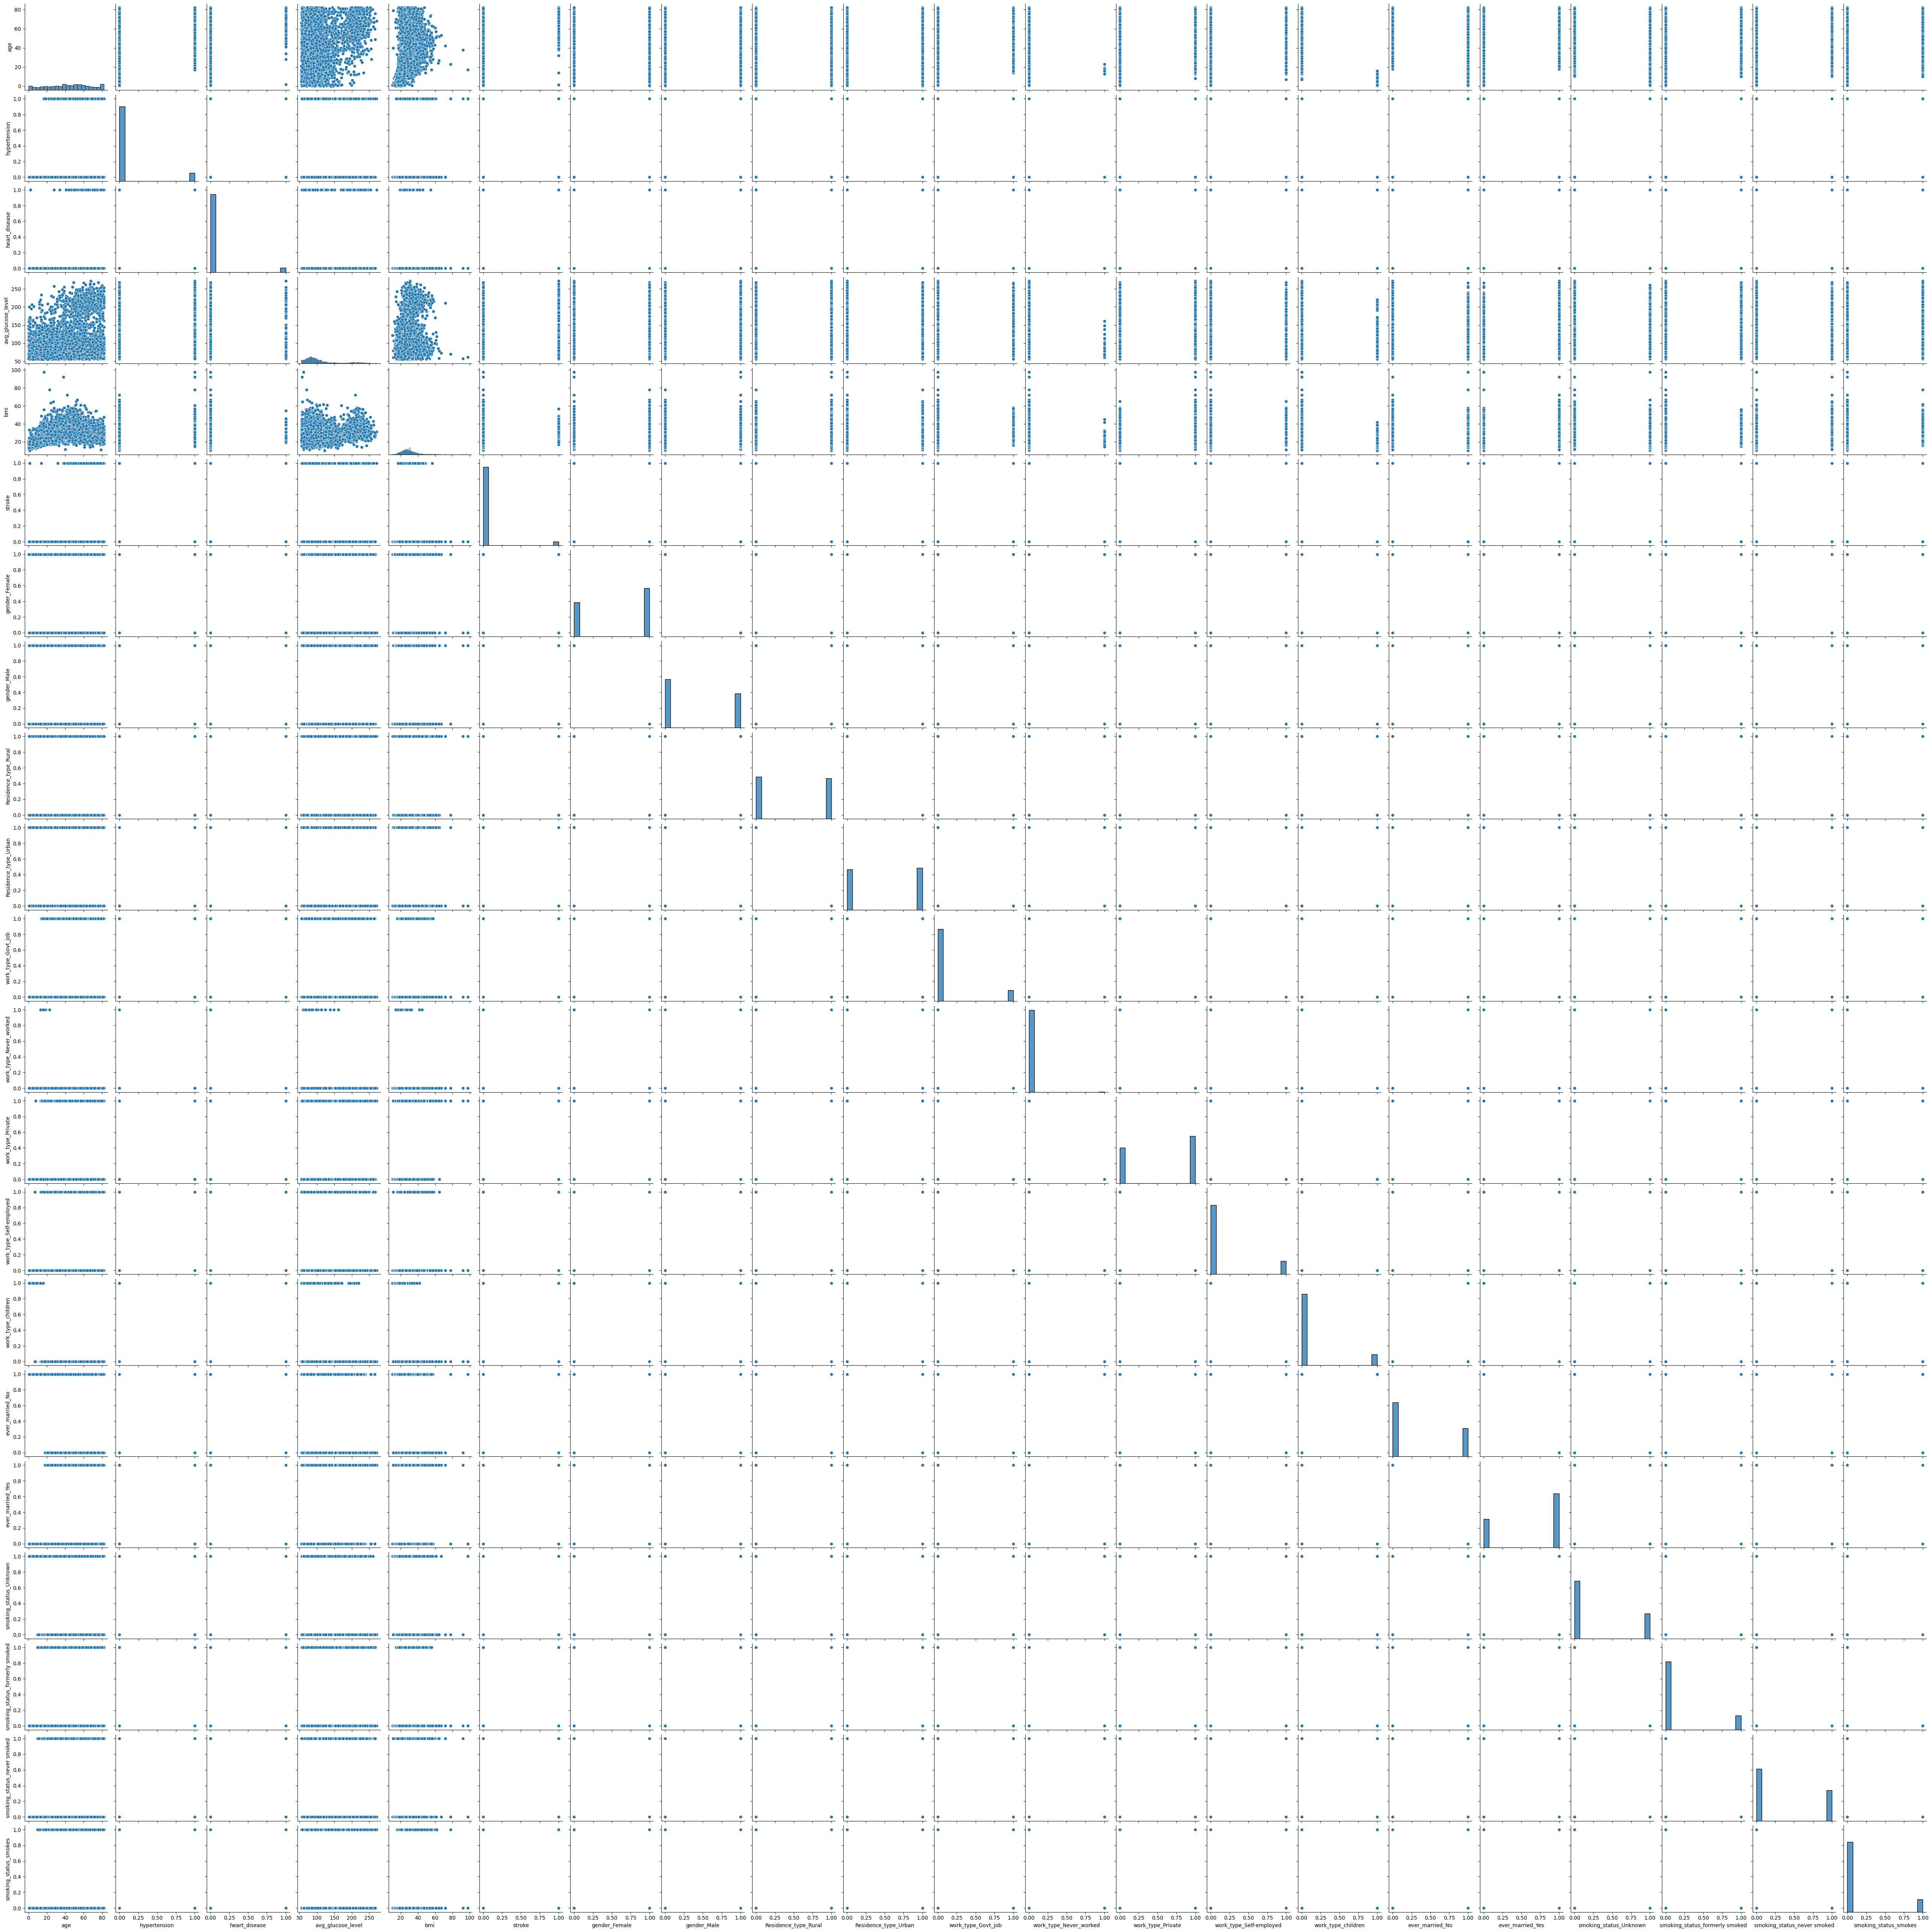

In [ ]:
sns.pairplot(stroke_encodedGRwEs)

In [ ]:
stroke_encodedGRwEs.isnull().sum()

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
stroke                            0
age_group                         0
gender_Female                     0
gender_Male                       0
Residence_type_Rural              0
Residence_type_Urban              0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
ever_married_No                   0
ever_married_Yes                  0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [ ]:
stroke_encodedGRwEs.head(5)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age_group,gender_Female,gender_Male,Residence_type_Rural,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,ever_married_No,ever_married_Yes,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.600000,1,>21,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,30.604579,1,>21,1,0,1,...,0,0,1,0,0,1,0,0,1,0
2,80.0,0,1,105.92,32.500000,1,>21,0,1,1,...,0,1,0,0,0,1,0,0,1,0
3,49.0,0,0,171.23,34.400000,1,>21,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.000000,1,>21,1,0,1,...,0,0,1,0,0,1,0,0,1,0


We will plot correlations between different variables using a heatmap (Predictor-Target Correlations:)

<ipython-input-76-0d4ad4c714cf>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = stroke_encodedGRwEs.corr()


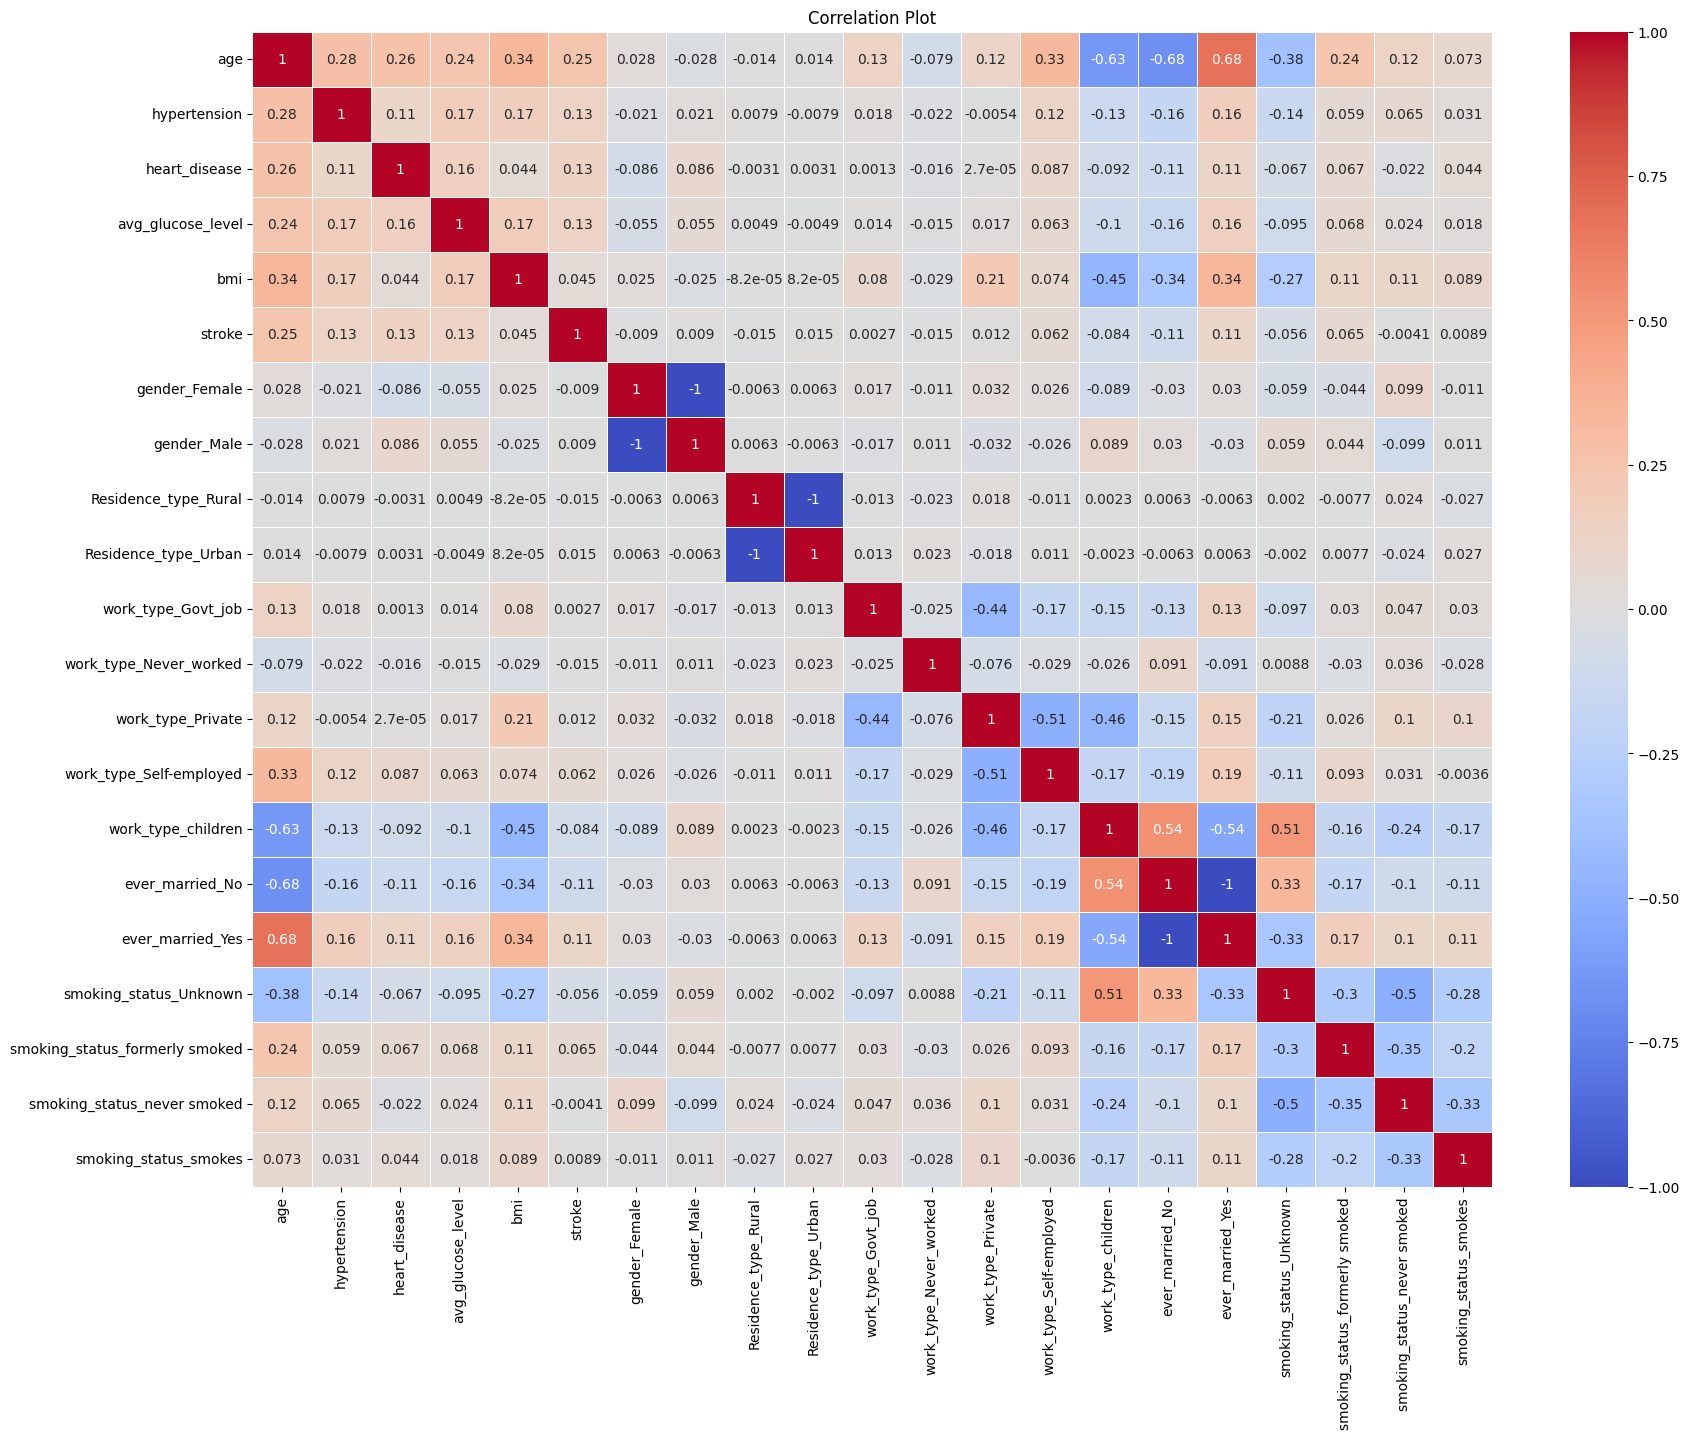

In [ ]:
# Calculate the correlation matrix
correlation_matrix = stroke_encodedGRwEs.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
corr_plot = sns.heatmap(correlation_matrix, annot=True, linewidths=0.5, cmap='coolwarm')
plt.title("Correlation Plot")

# Show the plot
plt.show()



In [ ]:
# as the columns are many, we just look at stroke vs other columns correlation.

selected_column = 'stroke'

# Calculate the correlation with the selected column
correlation_with_selected = stroke_encodedGRwEs.corr()[selected_column]

# Display correlation values
print("Correlation of '{}' with other columns:".format(selected_column))
print(correlation_with_selected)


Correlation of 'stroke' with other columns:
age                               0.245257
hypertension                      0.127904
heart_disease                     0.134914
avg_glucose_level                 0.131945
bmi                               0.044782
stroke                            1.000000
gender_Female                    -0.009027
gender_Male                       0.009027
Residence_type_Rural             -0.015458
Residence_type_Urban              0.015458
work_type_Govt_job                0.002677
work_type_Never_worked           -0.014882
work_type_Private                 0.011888
work_type_Self-employed           0.062168
work_type_children               -0.083869
ever_married_No                  -0.108340
ever_married_Yes                  0.108340
smoking_status_Unknown           -0.055892
smoking_status_formerly smoked    0.064556
smoking_status_never smoked      -0.004129
smoking_status_smokes             0.008939
Name: stroke, dtype: float64


<ipython-input-77-8cd8ded15b7f>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_selected = stroke_encodedGRwEs.corr()[selected_column]


In [ ]:
stroke_encodedGRwEs.sample(5)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age_group,gender_Female,gender_Male,Residence_type_Rural,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,ever_married_No,ever_married_Yes,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
1872,56.0,0,0,94.71,29.600000,0,>21,1,0,1,...,0,0,1,0,0,1,0,0,0,1
1718,59.0,0,1,188.69,30.604579,0,>21,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2916,38.0,0,0,77.35,27.700000,0,>21,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4153,79.0,1,0,72.04,23.600000,0,>21,0,1,0,...,0,0,1,0,0,1,0,1,0,0
1312,3.0,0,0,97.60,25.800000,0,<13,1,0,1,...,0,0,0,1,1,0,1,0,0,0


Let us streamline our predictor variables and target variables from the above modified stroke_encodedGRwEs. Let us drop age_group and stroke from the data, and call this stroke_encodedGRwEs_dropped, which represents our predictor variables. while column stroke is our target variable.

In [ ]:
columns_to_drop = ['age_group', 'stroke']

stroke_encodedGRwEs_dropped = stroke_encodedGRwEs.drop(columns=columns_to_drop)

# Display the modified DataFrame
print(stroke_encodedGRwEs_dropped.head(5))


    age  hypertension  heart_disease  avg_glucose_level        bmi  \
0  67.0             0              1             228.69  36.600000   
1  61.0             0              0             202.21  30.604579   
2  80.0             0              1             105.92  32.500000   
3  49.0             0              0             171.23  34.400000   
4  79.0             1              0             174.12  24.000000   

   gender_Female  gender_Male  Residence_type_Rural  Residence_type_Urban  \
0              0            1                     0                     1   
1              1            0                     1                     0   
2              0            1                     1                     0   
3              1            0                     0                     1   
4              1            0                     1                     0   

   work_type_Govt_job  work_type_Never_worked  work_type_Private  \
0                   0                       0   

For simplicity and based on correlation, we keep age, hypertension, heart_disease, avg_glucose_level, gender and Residence and can drop all columns related to work_type, marriage, smoking.

Also stroke chances are high if other health conditions exist. do read the following article for some insights

source: https://www.healthline.com/health/high-blood-pressure-hypertension/how-are-hypertension-heart-disease-and-stroke-related

Also, gender plays important role in deciding stroke as given in the healthline article. so let us remove drop bmi from our analysis.

https://www.healthline.com/health/stroke/signs-of-a-stroke#:~:text=Stroke%20in%20women%20vs.%20men%20Strokes%20caused%20by,are%20more%20fatal%20in%20women%20than%20men%20overall.

#5. Train-Test Split
We will divide the dataset into two subsets: train and test. To perform the train-test split, we’ll use Scikit-learn machine learning.

Train subset – we will use this subset to fit/train the model
Test subset – we will use this subset to evaluate our model

In [ ]:
#split data into dependent variables(X) and independent variable(y) that we would predict

#X = stroke_encodedGRwEs_dropped
#X = stroke_encodedGRwEs
y = stroke['stroke']
X = stroke[["age", "hypertension", "heart_disease","avg_glucose_level", "bmi"]]
#predictor_variables = ["gender", "age", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "avg_glucose_level", "bmi", "smoking_status"]

#Let’s split X and y using Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#get shape of train and test data
print("train size X : ",X_train.shape)
print("train size y : ",y_train.shape)
print("test size X : ",X_test.shape)
print("test size y : ",y_test.shape)

train size X :  (4088, 5)
train size y :  (4088,)
test size X :  (1022, 5)
test size y :  (1022,)


After splitting the dataset, we have 4088 observations in the training subset and 1022 in the test subset.

After diving into the dataset let’s move on to the next phase of feature scaling.

**Feature Scaling/Normalization**

Predictor variables: age, hypertension,  heart_disease,  avg_glucose_level,        bmi

Dependent (Target) Variables : stroke

In [ ]:
#Feature scaling
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

Class Imbalance : we already know that there is class imbalance

In [ ]:
#check for distribution of labels
y_train.value_counts(normalize=True)

0    0.954256
1    0.045744
Name: stroke, dtype: float64

We can observe that the majority of the labels are from class 0 and only a few are from class 1.

The model will start predicting every new observation as 0 or majority class. We’ll get more model accuracy here, but it won’t be a decent model because it won’t predict class 1 or minority class, which is a crucial class.

As a result, we must consider class imbalance when developing Regression models.

#6.Build and Train Logistic Regression model

To implement Logistic Regression, we will use the Scikit-learn library. We’ll start by building a base model with default parameters, then look at how to improve it with Hyperparameter Tuning.

we will use the “class_weight” parameter to address the problem of class imbalance. Let’s start by creating our base model with the code below.

1. **Logistic Regression**

Accuracy: 0.7446183953033269
Precision: 0.16040955631399317
Recall: 0.7580645161290323
F1-score: 0.26478873239436623
ROC-AUC: 0.8541666666666666
Intercept: -1.0485401664326774
Coefficients: [1.54185705 0.1391394  0.08752663 0.19371839 0.02212134]
Confusion Matrix:
  | Predicted Positive | Predicted Negative
--|--------------------|--------------------
Actual Positive | 47                 | 15                
Actual Negative | 246                | 714               


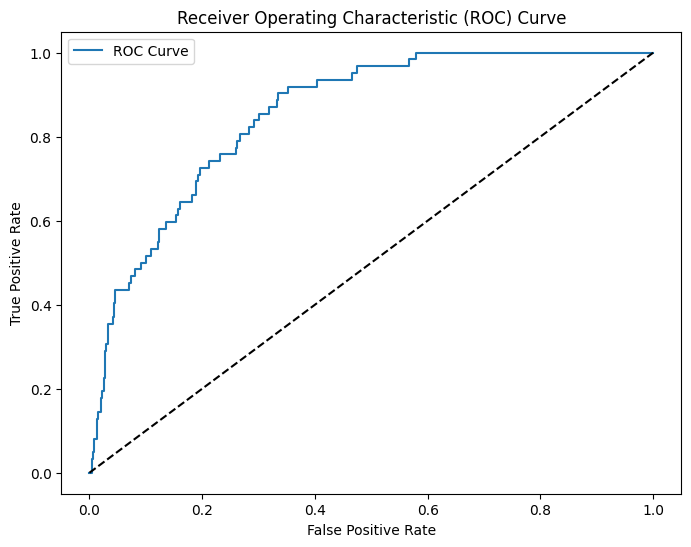

In [ ]:
# Import necessary libraries
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model
model = LogisticRegression(class_weight={0: 0.045, 1: 0.95})
model.fit(X_train, y_train)

# Make predictions and calculate probabilities
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

# Get the coefficients and intercept values
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probabilities)

# Print evaluation metrics and model parameters
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)
print("Intercept:", intercept)
print("Coefficients:", coefficients)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

# Print confusion matrix in desired layout
print("Confusion Matrix:")
print(f"  | Predicted Positive | Predicted Negative")
print(f"--|--------------------|--------------------")
print(f"Actual Positive | {cm[1][1]:<18} | {cm[1][0]:<18}")
print(f"Actual Negative | {cm[0][1]:<18} | {cm[0][0]:<18}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



Now let’s increase model performance and evaluate it again after tuning hyperparameters of the model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the Colab notebook to Google Drive
!cp 'path_to_your_notebook.ipynb' '/content/drive/My Drive/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat 'path_to_your_notebook.ipynb': No such file or directory


**2. Hyperparameter Optimization for the Logistic Regression Model**
We will use Grid Search which is the most basic method of searching optimal values for hyperparameters. To tune hyperparameters, follow the steps below:

Create a model instance of the Logistic Regression class
Specify hyperparameters with all possible values
Define performance evaluation metrics
Apply cross-validation
Train the model using the training dataset
Determine the best values for the hyperparameters given.
We can use the below code to implement hyperparameter tuning in python using the Grid Search method.

Accuracy: 0.860078277886497
Precision: 0.22448979591836735
Recall: 0.532258064516129
F1-score: 0.3157894736842105
ROC-AUC: 0.852486559139785
Intercept: -1.0485401664326774
Coefficients: [1.54185705 0.1391394  0.08752663 0.19371839 0.02212134]


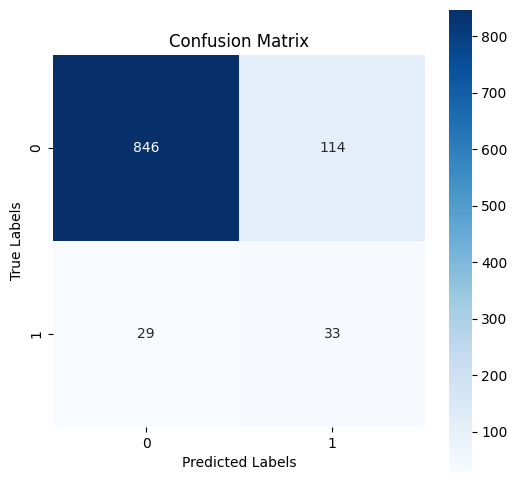

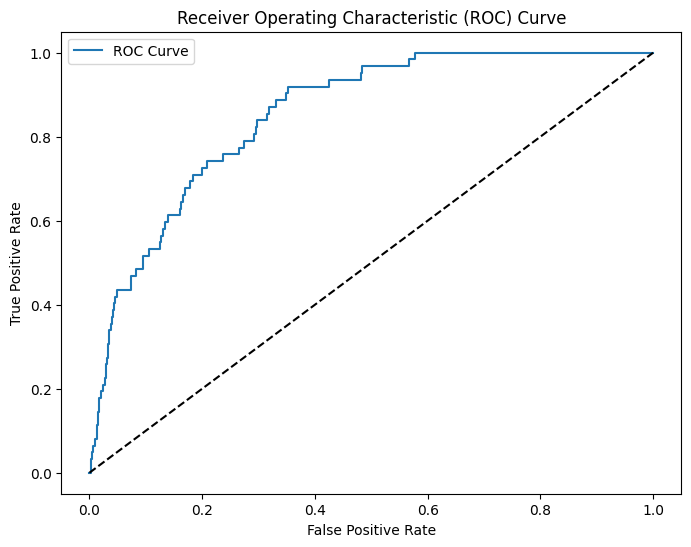

In [ ]:
import pickle
# Hyperparameter tuning
# Define model/create instance
lr = LogisticRegression(solver='liblinear')  # Use the 'liblinear' solver for L1 penalty

# Tuning weight for minority class then weight for majority class will be 1 - weight of minority class
# Setting the range for class weights
weights = np.linspace(0.0, 0.99, 500)

# Specifying all hyperparameters with possible values
param = {
    'C': [0.1, 0.5, 1, 10],
    'penalty': ['l1', 'l2'],  # Use 'l2' instead of 'l1'
    "class_weight": [{0: w, 1: 1.0 - w} for w in weights]
}

# Create 5 folds using KFold
folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Gridsearch for hyperparameter tuning with error_score='raise'
model = GridSearchCV(estimator=lr, param_grid=param, scoring="f1", cv=folds, return_train_score=True, error_score='raise')

# Save the trained model to a file
#with open('Model_Monday_Prob2_2BestResultOnly.pkl', 'wb') as model_file:
#    pickle.dump(model, model_file)

# Train model to learn relationships between X and y
try:
    model.fit(X_train, y_train)
except Exception as e:
    print("An error occurred during hyperparameter tuning:", e)

predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probabilities)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)
print("Intercept:", intercept)
print("Coefficients:", coefficients)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



In [ ]:
# THERE IS A IMPROVEMENT IN ACCURACY IMPROVED, ROC is similar

We can see that by tuning hyperparameters, we were able to improve the performance of our model since our F1 Score for the final model (0.316) is higher than that of the base model (0.265). After the hyperparameter tuning model got a 0.85 ROC-AUC score.

With this, we were able to construct our logistic regression model and test it on the Test dataset. More feature engineering, hyperparameter optimization, and cross-validation techniques can improve its performance even more.

**3. Support Vector Machine (20% test_size)**

Accuracy - Support Vector Machine: 0.7377690802348337
Precision - Support Vector Machine: 0.15894039735099338
Recall - Support Vector Machine: 0.7741935483870968
F1-score - Support Vector Machine: 0.26373626373626374


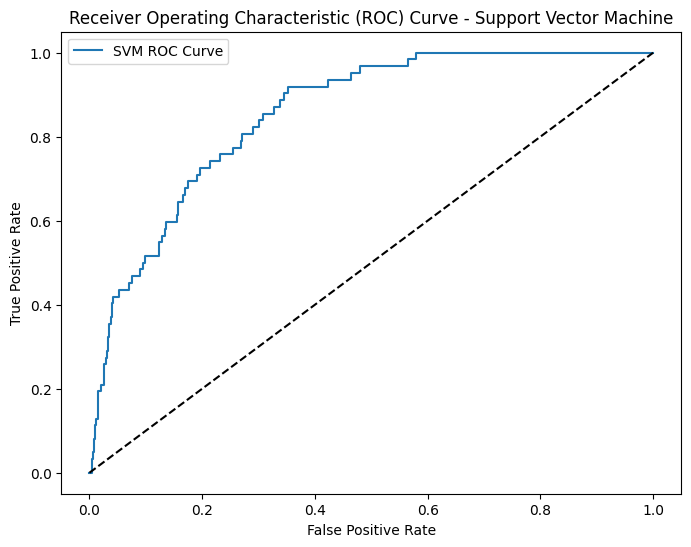

In [ ]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve
)
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Create SVM model with class weights
class_weights = {0: 0.045, 1: 0.95}
svm_model = SVC(kernel='linear', class_weight=class_weights)  # You can choose different kernels (linear, rbf, poly, etc.)

# Fit the model to the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test data
predictions_svm = svm_model.predict(X_test)

# Calculate accuracy and confusion matrix
accuracy_svm = accuracy_score(y_test, predictions_svm)
conf_matrix_svm = confusion_matrix(y_test, predictions_svm)

print("Accuracy - Support Vector Machine:", accuracy_svm)

# Calculate precision, recall, and F1-score
precision_svm = precision_score(y_test, predictions_svm)
recall_svm = recall_score(y_test, predictions_svm)
f1_svm = f1_score(y_test, predictions_svm)

print("Precision - Support Vector Machine:", precision_svm)
print("Recall - Support Vector Machine:", recall_svm)
print("F1-score - Support Vector Machine:", f1_svm)

# Calculate ROC curve
probabilities_svm = svm_model.decision_function(X_test)  # Use decision function for ROC curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, probabilities_svm)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label='SVM ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Support Vector Machine')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Create SVM model with class weights
class_weights = {0: 0.045, 1: 0.95}
svm_model = SVC(kernel='linear', class_weight=class_weights)  # You can choose different kernels (linear, rbf, poly, etc.)

# Fit the model to the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test data
predictions_svm = svm_model.predict(X_test)

# Calculate confusion matrix
conf_matrix_svm = confusion_matrix(y_test, predictions_svm)

# Print confusion matrix in desired layout
print("Confusion Matrix - Support Vector Machine:")
print(f"  | Predicted Positive | Predicted Negative")
print(f"--|--------------------|--------------------")
print(f"Actual Positive | {conf_matrix_svm[1][1]:<18} | {conf_matrix_svm[1][0]:<18}")
print(f"Actual Negative | {conf_matrix_svm[0][1]:<18} | {conf_matrix_svm[0][0]:<18}")


Confusion Matrix - Support Vector Machine:
  | Predicted Positive | Predicted Negative
--|--------------------|--------------------
Actual Positive | 48                 | 14                
Actual Negative | 254                | 706               


**4. Support Vector Machine (cross-validation & hyper parameter tuning)**

Best Parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy - Support Vector Machine: 0.7700587084148728
Precision - Support Vector Machine: 0.1607843137254902
Recall - Support Vector Machine: 0.6612903225806451
F1-score - Support Vector Machine: 0.2586750788643533
Confusion Matrix - Support Vector Machine:
  | Predicted Positive | Predicted Negative
--|--------------------|--------------------
Actual Positive | 41                 | 21                
Actual Negative | 214                | 746               


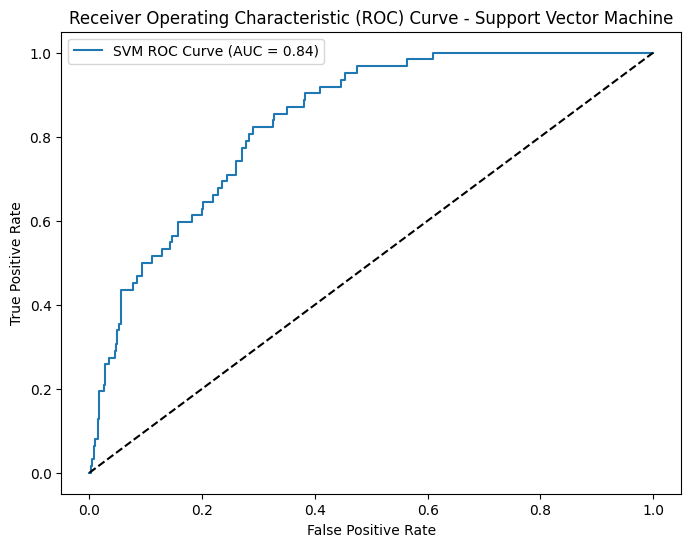

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt

# Define parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],    # Different values of the regularization parameter 'C'
    'gamma': [0.001, 0.0001],
    'kernel': ['linear', 'rbf']  # Different kernel types: linear and radial basis function (rbf)
}

# Specify class weights
class_weights = {0: 0.045, 1: 0.95}

# Hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(SVC(class_weight=class_weights), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

# Calculate ROC curve and AUC
probabilities = best_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = roc_auc_score(y_test, probabilities)

# Print results
print("Best Parameters:", grid_search.best_params_)
print("Accuracy - Support Vector Machine:", accuracy)
print("Precision - Support Vector Machine:", precision)
print("Recall - Support Vector Machine:", recall)
print("F1-score - Support Vector Machine:", f1)

# Print confusion matrix in desired layout
print("Confusion Matrix - Support Vector Machine:")
print(f"  | Predicted Positive | Predicted Negative")
print(f"--|--------------------|--------------------")
print(f"Actual Positive | {conf_matrix[1][1]:<18} | {conf_matrix[1][0]:<18}")
print(f"Actual Negative | {conf_matrix[0][1]:<18} | {conf_matrix[0][0]:<18}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='SVM ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Support Vector Machine')
plt.legend()
plt.show()


We can see that by tuning hyperparameters, we were able to improve since our ACCURACY for the final model  is higher than that of the base model. but ROC is similar and Confusion matrix is slightly different.

Remark: when we compared Logistic regression, Logistic Regression-Regularization, SVM, SVM-Regularization. The best is Logistic Regression with Regularization as its F1-Score is better than others. for problems where there is heavy imbalance, we look at F1 scores for performance.

**5. Gaussian Naive Bayes**

The Gaussian Naive Bayes implementation in scikit-learn does not directly support setting class weights or priors. Naive Bayes assumes independence between features and therefore doesn't have a concept of class weights in the same way as other algorithms like SVM or logistic regression.

**6. KNN classification method**

Accuracy: 0.8669275929549902
Precision: 0.19166666666666668
Recall: 0.3709677419354839
F1-score: 0.25274725274725274
Confusion Matrix:
  | Predicted Positive | Predicted Negative
--|--------------------|--------------------
Actual Positive | 23                 | 39                
Actual Negative | 97                 | 863               
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       960
           1       0.19      0.37      0.25        62

    accuracy                           0.87      1022
   macro avg       0.57      0.63      0.59      1022
weighted avg       0.91      0.87      0.89      1022

Precision (before ROC): 0.19166666666666668
Recall (before ROC): 0.3709677419354839
F1-score (before ROC): 0.25274725274725274


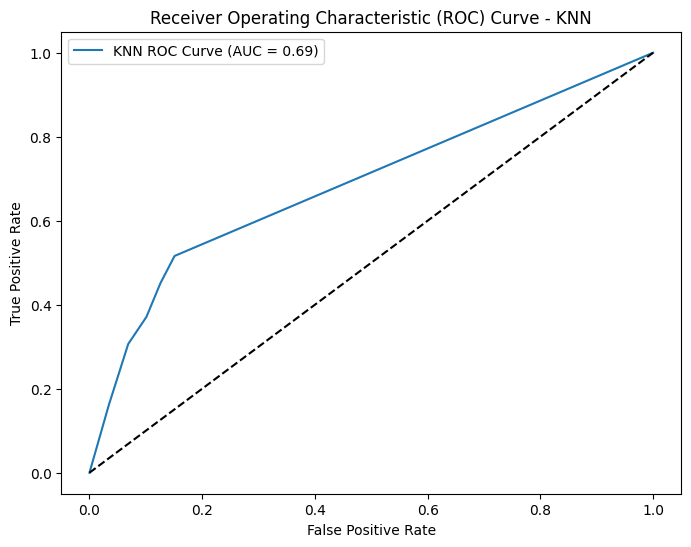

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

# Apply random oversampling to balance classes
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Create KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the resampled training data
knn_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = knn_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print accuracy before precision
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print precision, recall, and F1-score
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

print("Confusion Matrix:")
print(f"  | Predicted Positive | Predicted Negative")
print(f"--|--------------------|--------------------")
print(f"Actual Positive | {conf_matrix[1][1]:<18} | {conf_matrix[1][0]:<18}")
print(f"Actual Negative | {conf_matrix[0][1]:<18} | {conf_matrix[0][0]:<18}")
print("Classification Report:\n", class_report)

# Calculate ROC curve and AUC
probabilities = knn_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = roc_auc_score(y_test, probabilities)

# Print precision, recall, and F1-score before the ROC curve
print("Precision (before ROC):", precision)
print("Recall (before ROC):", recall)
print("F1-score (before ROC):", f1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='KNN ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
plt.legend()
plt.show()


**7. KNN classification method with hyper parameter tuning**

Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy: 0.8669275929549902
Precision: 0.25
Recall: 0.2903225806451613
F1-score: 0.2686567164179105
Confusion Matrix:
  | Predicted Positive | Predicted Negative
--|--------------------|--------------------
Actual Positive | 18                 | 44                
Actual Negative | 54                 | 906               
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       960
           1       0.25      0.29      0.27        62

    accuracy                           0.90      1022
   macro avg       0.60      0.62      0.61      1022
weighted avg       0.91      0.90      0.91      1022



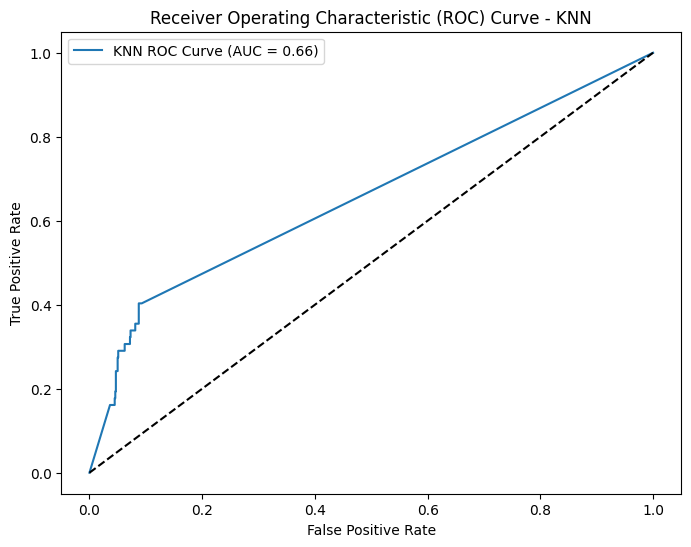

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

# Apply random oversampling to balance classes
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9],         # Different values for the number of neighbors
    'weights': ['uniform', 'distance'],  # Different weight options
    'p': [1, 2]                           # Different distance metrics (1: Manhattan, 2: Euclidean)
}

# Create KNN model
knn_model = KNeighborsClassifier()

# Apply GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Print confusion matrix in desired layout
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(f"  | Predicted Positive | Predicted Negative")
print(f"--|--------------------|--------------------")
print(f"Actual Positive | {conf_matrix[1][1]:<18} | {conf_matrix[1][0]:<18}")
print(f"Actual Negative | {conf_matrix[0][1]:<18} | {conf_matrix[0][0]:<18}")

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Calculate ROC curve and AUC
probabilities = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = roc_auc_score(y_test, probabilities)

# Print ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='KNN ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
plt.legend()
plt.show()


In [ ]:
#---------------END of regression modelling

#Conclusions

We began our learning journey by understanding the STROKE through various dimensions, such as stroke occurance among male and female, locations such as urban and rural etc. we found that, the chances of stroke occurance are as follows

1.	Female > Male
2.	Chances increase with age
3.	30 % (approx.)of them already suffer from hypertension
4.	25% (approx.)of them already suffer from heart disease
5.	Married >>> unmarried
6.	Private > Self-emp > Govt. > Children
7.	Urban> Rural
8.	Lower glucose or higher glucose can have higher changes
9.	Bmi at 30 as higher chances
10.	Smoking/non smoking

Then we moved on to the implementation of a several Regression model in Python. We did Data cleaning, EDA, Feature engineering, feature scaling, handling class imbalance problems, training, prediction, and evaluation of model on the test dataset. Apart from that, we learned how to use Hyperparameter Tuning to improve the performance of our model and avoid overfitting and underfitting. A total of 6 models starting from Logistic Regression till KNN with hyper parameter tuning were carriedout. There exists class imbalances, so they were handled using class-weights and by over sampling the minority class. Finally, the best model is

Logistic Regression-Regularization
Accuracy: 0.860078277886497
Precision: 0.22448979591836735
Recall: 0.532258064516129
F1-score: 0.3157894736842105
ROC-AUC: 0.852486559139785

